# 1. Business understanding









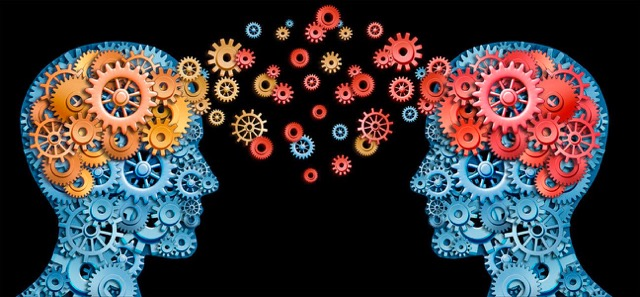

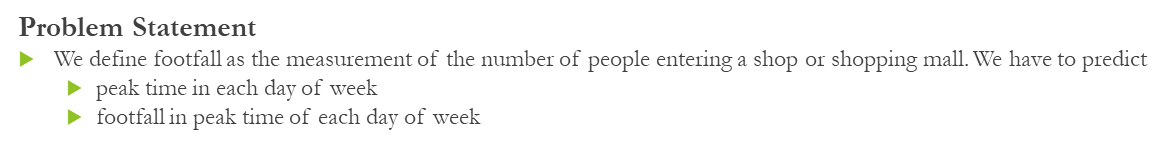

# 2. Data Acquisition 

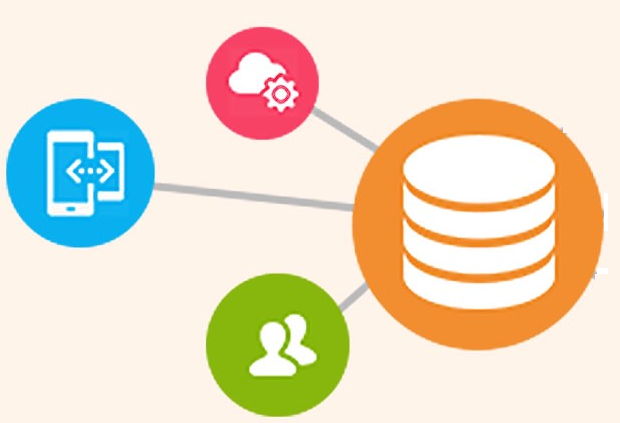

In [1]:
#from google.colab import drive    
#drive.mount('/content/gdrive/')

In [2]:
#!cp '/content/gdrive/My Drive/Colab Notebooks/LSTM/Mall Footfall prediction/visualization.py' .

In [3]:
!pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in c:\users\sudha\anaconda3\lib\site-packages (2.2.2)


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import calendar
from sklearn.preprocessing import MinMaxScaler
from category_encoders.target_encoder import TargetEncoder
import missingno as msno
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor

In [5]:
mainpath='https://raw.githubusercontent.com/syeelarthi/Footfall-prediction-code/master/'
df1 = pd.read_csv(mainpath+'footfall_Part1.csv')
df2 = pd.read_csv(mainpath+'footfall_Part2.csv')
df3 = pd.read_csv(mainpath+'footfall_Part3.csv')
df_foot_fall =pd.concat([df1,df2,df3])
df_weather_data= pd.read_csv(mainpath+'overall_weather.csv')
df_easter_sunday_holiday_data= pd.read_csv(mainpath+'Easter-Sundays.csv')
df_university_long_holidays_data= pd.read_csv(mainpath+'uni_hols_long.csv')
df_UK_bank_holidays_data= pd.read_csv(mainpath+'UKbankholidays.csv')
df_school_long_holidays_data= pd.read_csv(mainpath+'school_hols_long.csv')

# 3. Data preparation

In [6]:

df_foot_fall.shape


(554360, 15)

In [7]:
df_easter_sunday_holiday_data.shape

(18, 2)

In [8]:
df_foot_fall.info

<bound method DataFrame.info of               Date  InCount  BRCWeek          LocationName  Hour   Weekday  \
0       01-01-2009      268       53              Briggate     0  Thursday   
1       01-01-2009      366       53              Briggate     1  Thursday   
2       01-01-2009      273       53              Briggate     2  Thursday   
3       01-01-2009      219       53              Briggate     3  Thursday   
4       01-01-2009      132       53              Briggate     4  Thursday   
...            ...      ...      ...                   ...   ...       ...   
154357  31-12-2016      205       52  CommercialStBarratts    23  Saturday   
154358  31-12-2016      405       52               Headrow    23  Saturday   
154359  31-12-2016      353       52            DortmundSq    23  Saturday   
154360  31-12-2016      348       52         AlbionStSouth    23  Saturday   
154361  31-12-2016      316       52         AlbionStNorth    23  Saturday   

          NewDate  Month  Year 

In [9]:
df_foot_fall.head()

Date  InCount  BRCWeek LocationName  Hour   Weekday    NewDate  \
0  01-01-2009      268       53     Briggate     0  Thursday  01-Jan-09   
1  01-01-2009      366       53     Briggate     1  Thursday  01-Jan-09   
2  01-01-2009      273       53     Briggate     2  Thursday  01-Jan-09   
3  01-01-2009      219       53     Briggate     3  Thursday  01-Jan-09   
4  01-01-2009      132       53     Briggate     4  Thursday  01-Jan-09   

   Month  Year  Day                Day_yr Month_yr  Week_yr          Hour_yr  \
0      1  2009    1  Thursday/01-Jan-2009   Jan-09  00-2009  00, 01-Jan-2009   
1      1  2009    1  Thursday/01-Jan-2009   Jan-09  00-2009  00, 01-Jan-2009   
2      1  2009    1  Thursday/01-Jan-2009   Jan-09  00-2009  00, 01-Jan-2009   
3      1  2009    1  Thursday/01-Jan-2009   Jan-09  00-2009  00, 01-Jan-2009   
4      1  2009    1  Thursday/01-Jan-2009   Jan-09  00-2009  00, 01-Jan-2009   

   week_no  
0        1  
1        1  
2        1  
3        1  
4        1

In [10]:
df_foot_fall.shape

(554360, 15)

In [11]:
class MultiColumnEncoder:
    def __init__(self,Categoricalcolumns = None,includedcolumns=None):
        self.columns = Categoricalcolumns # array of column names to encode
        self.included_cols = includedcolumns

    def fit(self,X,y=None):
        return self # not relevant here

    def transform_LabelEncoder(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def onehot_encode_integers(self, df):
        df = df.copy()
        df_encoded = pd.get_dummies(df, columns = self.included_cols)
        return df_encoded
 
    def fit_transform(self,X,y=None,encoding_type = 'target_encoding'):
      if encoding_type == 'onehot_encoding':
        return self.onehot_encode_integers(X) 
      elif encoding_type == 'target_encoding':
        return self.target_encoding(X,y)

    def target_encoding(self,X, target_column):
        return TargetEncoder(cols=self.included_cols).fit_transform(X,X[target_column])
        
    

In [12]:
class Lagging:  
  def __init__(self, location_name_list=None, n_timesteps=7, n_forecast_steps=1):
      self.n_timesteps = n_timesteps
      self.location_name_list = location_name_list # array of locations
      self.n_forecast_steps = n_forecast_steps

  def createforecastTargetVariables(self, df):
    # copy the InCount to other forecast columns
    for forecast_step in range(1, self.n_forecast_steps+1): 
      df['InCountTotal'+'_forecast'+str(forecast_step)] = df['InCountTotal']
          
    #update multistep output variables
    for i in range(0, df.shape[0]-self.n_forecast_steps):
      for forecast_step in range(1, self.n_forecast_steps+1): 
        df['InCountTotal'+'_forecast'+str(forecast_step)][i] = df['InCountTotal'][i+forecast_step]
      
    #remove the last nforecast rows as these do not have proper values after creating the forecast variables
    df.drop(df.tail(self.n_forecast_steps).index,inplace=True)
    return df

  def createLagVariables(self,df): #Create lag variables of size=n_timesteps
      if location_wise_data == True:#location wise data
        for location in self.location_name_list:
            location = 'InCount'+location
            for lag in range(1, self.n_timesteps+1):
                df[location+'_lag'+str(lag)] = df[location].shift(periods=lag)
      else:# totalincount only
        for lag in range(1, self.n_timesteps):
            df['InCountTotal'+'_lag'+str(lag)] = df['InCountTotal'].shift(periods=lag)
        
      df.dropna(inplace = True)
      return df

  def createLagDiffVariables(self,df,location_wise_data = True): #Create lag variables of size=n_timesteps
    if location_wise_data == True:#location wise data
      for location in self.location_name_list:
        location = 'InCount'+location
        for lag in range(1, self.n_timesteps+1):
          df[location+'_lag'+str(lag)] = df[location].diff(periods=lag)
    else:# totalincount only
      for lag in range(1, self.n_timesteps+1):
          df['InCountTotal'+'_lag'+str(lag)] = df['InCountTotal'].diff(periods=lag)
    
    df.dropna(inplace = True)
    return df


In [13]:
class pre_processing:
  def __init__(self,data_frame):
        self.data_frame = data_frame # which data_frame to pre-process
        self.location_name_list = []
        self.location_name_col_list=[]
        self.scaler_target = MinMaxScaler(feature_range = (0, 1))
        self.scaler_input = MinMaxScaler(feature_range = (0,1))
  def cleanup_data(self, col_name='Date'):
     # there is a white space in one of the date values in Easter holidays list. We need to remove that
     if( col_name in self.data_frame.columns):
        self.data_frame[col_name] = self.data_frame[col_name].str.replace(' ', '')
     return self.data_frame 
  def aggregate(self,group_by_cols, retain_list): 
      '''
      aggregate the column values based on conditions
      ''' 
      retain_list = {}
      # add all the location name columns to retain list
      for location_name in self.location_name_list:
        key = 'InCount'+location_name
        retain_list[key] = 'sum'
      # now aggregate based on Date
      self.data_frame = self.data_frame.groupby(group_by_cols).agg(retain_list).reset_index()
      return self.data_frame

  def reshape_location_name(self, group_by_cols, target_col='InCount'):# Review this
      
      data_temp_df = pd.DataFrame(data=self.data_frame[['Date','Weekday','Month']])
      data_temp_df.drop_duplicates('Date', inplace=True)
      
      self.location_name_list = self.data_frame["LocationName"].unique()

      self.data_frame = self.data_frame.pivot_table(index=group_by_cols, columns='LocationName',values=[target_col]).reset_index()
      self.data_frame.columns = [''.join(col) for col in self.data_frame.columns]
            
      return self.data_frame.merge(data_temp_df, on='Date', how='inner')

  def encode_variables(self,included_cols, target_variable = 'InCountTotal', encoding_type = 'target_encoding'):
      '''
      categorical/target encoding of the column values
      '''
      self.data_frame = MultiColumnEncoder(includedcolumns = included_cols).fit_transform(self.data_frame,target_variable,encoding_type = 'target_encoding')
      return self.data_frame
  def imputeData(self): 
      # fill missing values with mean column values as only missing column i see is InCountAlbionStSouth
      #print('impute data')
      self.data_frame.fillna(self.data_frame.mean(), inplace=True)
      return self.data_frame
  def pre_process(self,data_frame_type='Foot_Fall'):
      '''
      for different data frame types, do the different pre-processibg
      ''' 
      
      if(data_frame_type=='Foot_Fall'):
        
        self.reshape_location_name(['Date','Hour'])
        self.data_frame = self.imputeData()

        self.aggregate('Date', 'Dummy-To be removed') 
        # add the incountTotal column for the total mall's incount 
        self.addTotalIncountColumn()
       

        for i in range(len(self.data_frame)):
              self.data_frame['Date'].iloc[i]=self.data_frame['Date'].iloc[i].replace('Jan-', '01-20').replace('Feb-', '02-20').replace('Mar-', '03-20').replace('Apr-', '04-20').replace('May-', '05-20').replace('Jun-', '06-20').replace('Jul-', '07-20').replace('Aug-', '08-20').replace('Sep-', '09-20').replace('Oct-', '10-20').replace('Nov-', '11-20').replace('Dec-', '12-20')

        self.data_frame['Date'] = pd.to_datetime(self.data_frame['Date'], format = '%d-%m-%Y').dt.strftime('%d/%m/%Y')
        self.data_frame['Month']=pd.to_datetime(self.data_frame['Date'], format = '%d/%m/%Y').dt.month
        self.data_frame['Year']=pd.to_datetime(self.data_frame['Date'], format = '%d/%m/%Y').dt.year
        self.data_frame['Day']=pd.to_datetime(self.data_frame['Date'], format = '%d/%m/%Y').dt.day
        self.data_frame['Weekday']=pd.to_datetime(self.data_frame['Date'], format = '%d/%m/%Y').dt.weekday
        self.data_frame['Week_no']=pd.to_datetime(self.data_frame['Date'], format = '%d/%m/%Y').dt.week
        
        for i in range(len(self.data_frame)):
            self.data_frame['Weekday'].iloc[i]=calendar.day_name[self.data_frame['Weekday'].iloc[i]]

        self.data_frame['Date'] = pd.to_datetime(self.data_frame['Date'], format = '%d/%m/%Y').dt.strftime('%d-%m-%Y')
        '''group_by_cols = ['Date','Hour']
        
        self.data_frame = self.reshape_location_name(group_by_cols)
        self.data_frame = self.imputeData()   
        retain_list = {'Weekday': 'first', 'Month': 'first'}
        # add all the location name columns to retain list
        for location_name in self.location_name_list:
          key = 'InCount'+location_name
          retain_list[key] = 'sum'
        # now aggregate based on Date
        self.data_frame = self.aggregate(['Date'],retain_list) '''

      elif (data_frame_type == 'EasterSunday'):
          # cleanup the date columns
          self.data_frame  = self.cleanup_data(col_name='Date')
      
      return self.data_frame

  def merge_data(self, data_to_merge, col_by ='Date'):
      self.data_frame = self.data_frame.merge(data_to_merge, how='inner', left_on=col_by, right_on=col_by)
      return self.data_frame
  def add_new_column(self, data_to_add, new_col_name, source_date_format = '%d-%m-%Y', destination_date_format = '%m-%d-%Y' ):
      self.data_frame['Tempcolumn'] = pd.to_datetime(self.data_frame['Date'], format = source_date_format).dt.strftime('%d/%m/%Y')

      temp_data = data_to_add.copy()

      temp_data['Tempcolumn'] = pd.to_datetime(temp_data['Date'],format = destination_date_format).dt.strftime('%d/%m/%Y')

      self.data_frame[new_col_name] = (self.data_frame.set_index(['Tempcolumn']).index.isin(temp_data.set_index(['Tempcolumn']).index)).astype(int)
      temp_data.drop(['Tempcolumn'],axis=1)

      self.data_frame.drop(['Tempcolumn'],axis=1, inplace=True)
      
      return self.data_frame

  def createTimeSeries(self):
      self.data_frame["DateTime"] = pd.to_datetime(self.data_frame.Date.astype(str))
      self.data_frame = self.data_frame.set_index("DateTime")
      self.data_frame.drop(['Date'], inplace=True, axis=1)
      self.data_frame = self.data_frame.sort_index()
      return self.data_frame
 
  def checkForMissingValues(self, location_name_list):
        for location in location_name_list:
            self.data_frame.loc[self.data_frame[self.data_frame['InCount'+location]==0].index,'InCount'+location] = np.NaN
        return self.data_frame
  
  def createLag_ForecastVariables(self,location_name_list=None, n_timesteps=7,n_forecast_steps = 1, location_wise_data = True):
      nLagClass = Lagging(location_name_list,n_timesteps, n_forecast_steps)
      #self.data_frame = nLagClass.createLagVariables(self.data_frame)
      # create lag data for total mall incount
      self.data_frame = nLagClass.createLagDiffVariables(self.data_frame, location_wise_data = location_wise_data)
      self.data_frame = nLagClass.createforecastTargetVariables(self.data_frame)
      
      return self.data_frame

  def addTotalIncountColumn(self):
    self.location_name_col_list=['InCount'+x for x in self.location_name_list]
    self.data_frame['InCountTotal'] = self.data_frame[self.location_name_col_list].sum(axis=1)
    self.data_frame['InCountTotal'] = self.data_frame['InCountTotal'].astype(int)
    return self.data_frame

  def normalizeTargetVariable(self):
    #print('normalization')
    self.data_frame[['InCountTotal']] = self.scaler_target.fit_transform(self.data_frame[['InCountTotal']])

    location_name_col_list=['InCount'+x for x in self.location_name_list]
    for location_col in location_name_col_list:
      self.data_frame[[location_col]] = self.scaler_target.fit_transform(self.data_frame[[location_col]])
    return self.data_frame

  def normalizeInputVariables(self, included_cols=None):
     #print('normalize input variables')
     self.data_frame[included_cols] = self.scaler_input.fit_transform(self.data_frame[included_cols])
     return self.data_frame

  def visualizeMissingValues(self):
       #print('missing values visualization')
       msno.bar(self.data_frame)
        
  def imputeDataWithKnn(self):
    X = self.data_frame[['InCountCommercialStBarratts', 'InCountCommercialStLush']]
    imputer = KNNImputer(n_neighbors=2)
    imputed_df = imputer.fit_transform(X)
    imputed_df = pd.DataFrame(imputed_df, columns=X.columns)
    #print(imputed_df)
    #print(self.data_frame['InCountCommercialStBarratts'])
    self.data_frame['InCountCommercialStBarratts'] = imputed_df.values
    return self.data_frame


  def findoutliers_DBSCAN(self,columns,number_near):
      # This finction takes as input, the dataframe name, columns to be analysed for the outlier, nearesr neighbours to be considered as input
      # A new boolean column for outlier will be added with name Outlier_+column name and it will have values 1  If outlier and 0 otherwise
      # optimal eps is calculated based on distances
      nc=0
      fig, axs = plt.subplots(len(columns),figsize=(15,15))
      fig.tight_layout(pad=3.0)
      for col in columns:
          # finding the distances based on nearest neighbour to find optimal eps
          neigh = NearestNeighbors(n_neighbors=number_near)
          nbrs = neigh.fit(np.array(self.data_frame[col]).reshape(-1,1))
          distances, indices = nbrs.kneighbors(np.array(self.data_frame[col]).reshape(-1,1))
          distances = np.sort(distances, axis=0)
          distances = distances[:,1]
      
          # If plotted on a graph, a point with maximum curvature. , ie, a point with maximum slope gives the best eps
          maxslope=0
          neps=0
          diff=[] # A list to hold the differences in the distances
          for i in range (len(distances)-1):
              slope=( (distances[i]-distances[i+1])/(indices[i][0]-indices[i+1][0]))
              if (slope<1 and maxslope<slope):
                  maxslope=slope
                  neps=distances[i]
          db=DBSCAN(eps=neps, min_samples=number_near).fit(np.array(self.data_frame[col]).reshape(-1,1))
          labels=db.labels_
          self.data_frame['Outliers_'+col] = [1 if val ==-1 else 0 for val in labels]
          # Visualizing the Outliers marked   
          outlier=[]
          outlierindex=[]
          datapoint=[]
          dataindex=[]
          for j in range(len(labels)):
              if (labels[j]==-1):
                  outlier.append(self.data_frame[col][j])
                  outlierindex.append(indices[j][0])
              else:
                  datapoint.append(self.data_frame[col][j])
                  dataindex.append(indices[j][0])
          axs[nc].scatter(outlierindex,outlier,color='red')
          axs[nc].scatter(dataindex,datapoint,color='blue')
          axs[nc].set_title(col+" DBCSAN Outlers marked in Red")
          nc=nc+1
          n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
          n_noise_ = list(labels).count(-1)
          print(col+'Analysis')
          print('Optimal eps is ',neps)
          print('Estimated number of clusters: %d' % n_clusters_)
          print('Estimated number of noise points: %d' % n_noise_)
      plt.show
      return self.data_frame
  def findoutliers_lof(self,columns,number_near):
      # This finction takes as input, the dataframe name, columns to be analysed for the outlier, nearesr neighbours to be considered as input
      # A new boolean column for outlier will be added with name Outlier_+column name and it will have values 1  If outlier and 0 otherwise
  
      nc=0
      fig, axs = plt.subplots(len(columns),figsize=(15,15))
      fig.tight_layout(pad=3.0)
      for col in columns:
          clf = LocalOutlierFactor(n_neighbors=number_near)
          pred=clf.fit_predict(np.array(self.data_frame[col]).reshape(-1,1))
          #scores = clf.negative_outlier_factor_
          self.data_frame['Lof_Outlier'+col]=[1 if val ==-1 else 0 for val in pred]
    
          # Visualizing the Outliers marked   
          outlier=[]
          outlierindex=[]
          datapoint=[]
          dataindex=[]

          for j in range(len(self.data_frame['Lof_Outlier'+col])):
              if (self.data_frame['Lof_Outlier'+col][j]==1):
                  outlier.append(self.data_frame[col][j])
                  outlierindex.append(j+1)
              else:
                  datapoint.append(self.data_frame[col][j])
                  dataindex.append(j+1)

          axs[nc].scatter(dataindex,datapoint,color='blue')
          axs[nc].scatter(outlierindex,outlier,color='red')
          axs[nc].set_title(col+" LOF Outlers marked in Red")
          nc=nc+1
      return self.data_frame


In [14]:
def do_all_pre_processing(for_visualization_only = False):
  global df_easter_sunday_holiday_data, df_university_long_holidays_data, df_school_long_holidays_data, df_UK_bank_holidays_data

  # process the main data set
  pre_process_foot_fall = pre_processing(df_foot_fall)
  pre_process_foot_fall.pre_process(data_frame_type='Foot_Fall')

  if for_visualization_only == False:
    # Normalize the inCount columns
    pre_process_foot_fall.normalizeTargetVariable()
    

  # store the location name list
  location_name_list = pre_process_foot_fall.location_name_list

  # Merge weather data and foot fall data based on date
  data_final = pre_process_foot_fall.merge_data(df_weather_data, col_by='Date')


  # add new column for EasterHolidays
  pre_process_easter_sunday_data = pre_processing(df_easter_sunday_holiday_data)
  df_easter_sunday_holiday_data = pre_process_easter_sunday_data.pre_process(data_frame_type='EasterSunday') 
  pre_process_foot_fall.add_new_column(df_easter_sunday_holiday_data,'EasterSundayHoliday', destination_date_format = '%m-%d-%Y' )
  
  # add a new column for university holidays
  pre_process_foot_fall.add_new_column(df_university_long_holidays_data,'University_holidays', destination_date_format = '%d-%b-%y' )
  
  # add a new column for School holidays
  pre_process_foot_fall.add_new_column(df_school_long_holidays_data,'School_holidays', destination_date_format = '%d-%b-%y' )

  # add a new column for UK Bank holidays
  pre_process_foot_fall.add_new_column(df_UK_bank_holidays_data,'UKBankHoliday', destination_date_format = '%d-%b-%y' )
  
  if for_visualization_only == False: 
    # encode the variable - categorial with one-hotencoding or target encoding
    pre_process_foot_fall.encode_variables(['Weekday','Month','Day','Year', 'Week_no'], target_variable = 'InCountTotal', encoding_type = 'target_encoding')

  # create time series 
  pre_process_foot_fall.createTimeSeries()

  #check if there are any locations which has the 0 count for a particular day, if yes consider that as missing value and impute value
  data_final = pre_process_foot_fall.checkForMissingValues(location_name_list)  
  
  if for_visualization_only == True: 
    pre_process_foot_fall.visualizeMissingValues()
  # impute the missing data
    #Based on visualization we see there are only 2 missing values for CommercialStBarratts, will use the KNN for imputing the missing values
    data_final = pre_process_foot_fall.imputeDataWithKnn()

  if for_visualization_only == False: 
    # N-lag Days: Create lag variables for each gate/location 
    pre_process_foot_fall.createLag_ForecastVariables(location_name_list, n_timesteps=7, n_forecast_steps = 7, location_wise_data = False)
    # normalize input variables
    data_final = pre_process_foot_fall.normalizeInputVariables(['mean_temp','rain','wind_speed'])

  if for_visualization_only == False:   
    data_final = pre_process_foot_fall.findoutliers_DBSCAN(pre_process_foot_fall.location_name_col_list,number_near=7)
    data_final = pre_process_foot_fall.findoutliers_lof(pre_process_foot_fall.location_name_col_list,number_near=7)


  return data_final, location_name_list, pre_process_foot_fall.scaler_target, pre_process_foot_fall.scaler_input

InCountBriggateAnalysis
Optimal eps is  0.020594942063827837
Estimated number of clusters: 3
Estimated number of noise points: 10
InCountBriggateAtMcDsAnalysis
Optimal eps is  0.01731921849459006
Estimated number of clusters: 2
Estimated number of noise points: 28
InCountAlbionStNorthAnalysis
Optimal eps is  0.008370795225546401
Estimated number of clusters: 3
Estimated number of noise points: 28
InCountAlbionStSouthAnalysis
Optimal eps is  0.04999679859504058
Estimated number of clusters: 1
Estimated number of noise points: 7
InCountCommercialStLushAnalysis
Optimal eps is  0.010036096810462136
Estimated number of clusters: 1
Estimated number of noise points: 33
InCountHeadrowAnalysis
Optimal eps is  0.02677238217417821
Estimated number of clusters: 1
Estimated number of noise points: 8
InCountDortmundSqAnalysis
Optimal eps is  0.01069656257564755
Estimated number of clusters: 1
Estimated number of noise points: 24
InCountCommercialStBarrattsAnalysis
Optimal eps is  0.01158964086421521

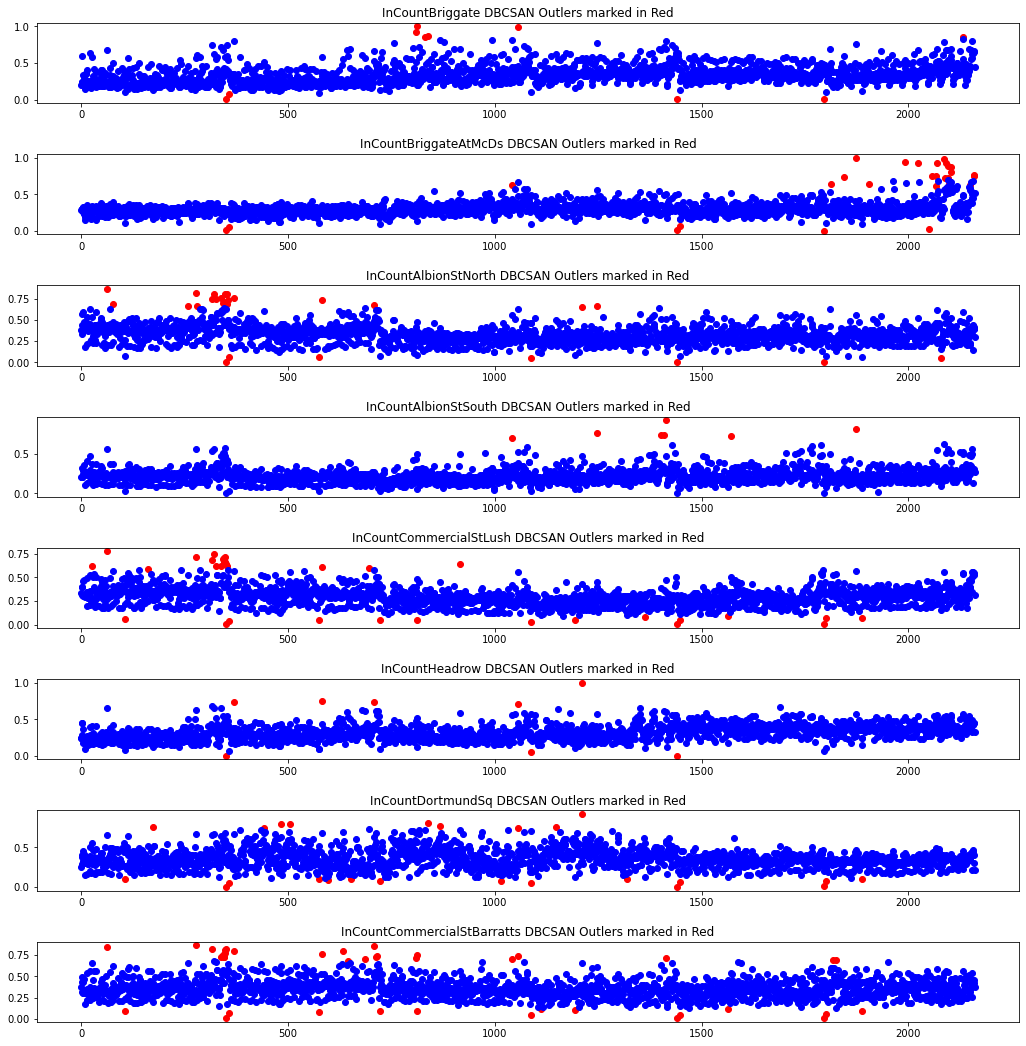

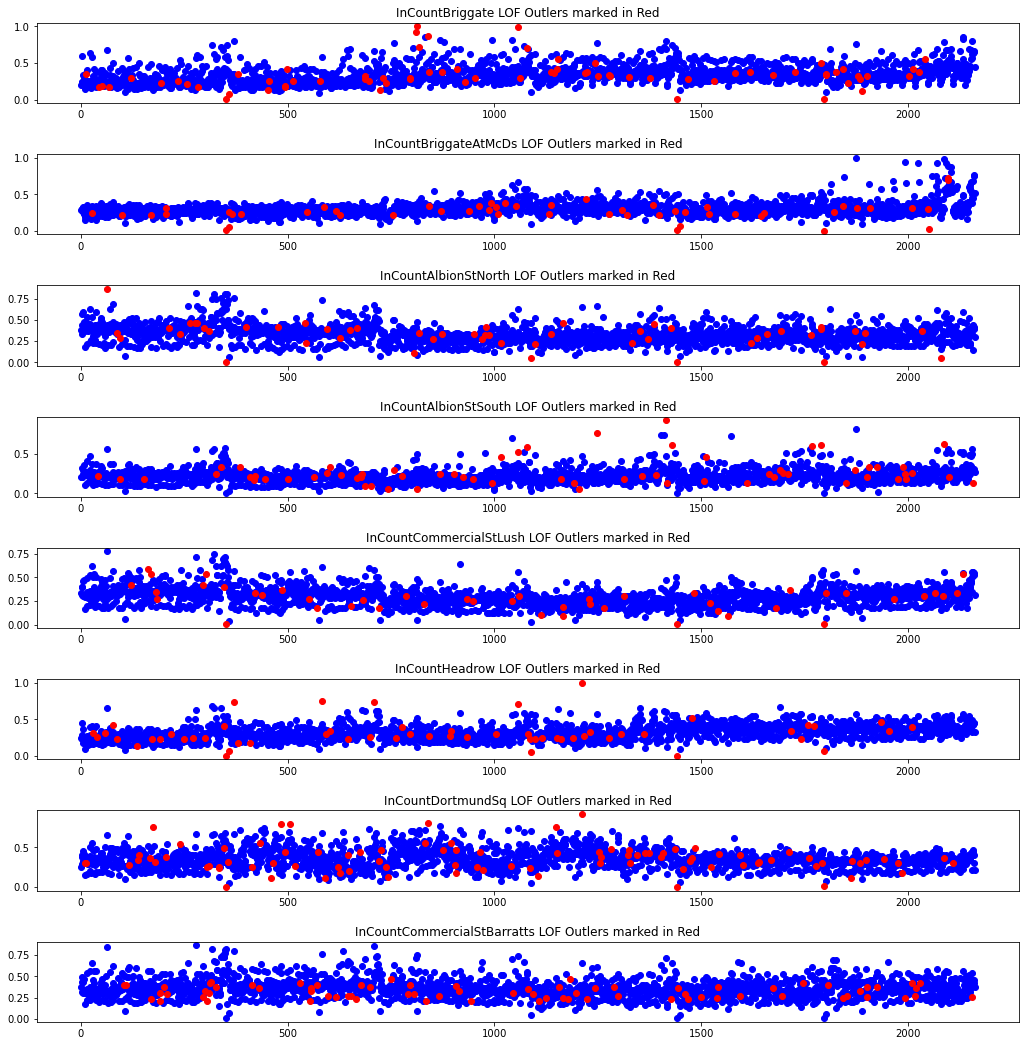

In [15]:
data_final, location_name_list, scaler_target, scaler_input  = do_all_pre_processing()


In [16]:
data_final.describe()

InCountBriggate  InCountBriggateAtMcDs  InCountAlbionStNorth  \
count      2161.000000            2161.000000           2161.000000   
mean          0.337442               0.304484              0.329905   
std           0.124867               0.091669              0.102057   
min           0.002641               0.005235              0.002635   
25%           0.248429               0.253230              0.266935   
50%           0.319469               0.293979              0.323516   
75%           0.394626               0.333813              0.380968   
max           1.000000               1.000000              0.865350   

       InCountAlbionStSouth  InCountCommercialStLush  InCountHeadrow  \
count           2161.000000              2161.000000     2161.000000   
mean               0.219812                 0.294692        0.322801   
std                0.086061                 0.094261        0.098293   
min                0.000823                 0.002592        0.004290   
25%                0.174193                 0.231990        0.252918   
50%                0.207259                 0.292408        0.313550   
75%                0.250533                 0.344115        0.383730   
max                0.920322                 0.773478        1.000000   

       InCountDortmundSq  InCountCommercialStBarratts  InCountTotal  \
count        2161.000000                  2161.000000   2161.000000   
mean            0.357440                     0.353800      0.362051   
std             0.115474                     0.108604      0.096183   
min             0.001589                     0.007601      0.002429   
25%             0.288278                     0.285109      0.309579   
50%             0.344680                     0.343504      0.351102   
75%             0.420177                     0.405512      0.402333   
max             0.915154                     0.864555      0.820060   

             Month  ...  Outliers_InCountDortmundSq  \
count  2161.000000  ...                 2161.000000   
mean      0.361373  ...                    0.011106   
std       0.031937  ...                    0.104822   
min       0.298660  ...                    0.000000   
25%       0.351155  ...                    0.000000   
50%       0.354764  ...                    0.000000   
75%       0.382258  ...                    0.000000   
max       0.441976  ...                    1.000000   

       Outliers_InCountCommercialStBarratts  Lof_OutlierInCountBriggate  \
count                           2161.000000                 2161.000000   
mean                               0.018510                    0.033781   
std                                0.134817                    0.180706   
min                                0.000000                    0.000000   
25%                                0.000000                    0.000000   
50%                                0.000000                    0.000000   
75%                                0.000000                    0.000000   
max                                1.000000                    1.000000   

       Lof_OutlierInCountBriggateAtMcDs  Lof_OutlierInCountAlbionStNorth  \
count                       2161.000000                      2161.000000   
mean                           0.024063                         0.024063   
std                            0.153280                         0.153280   
min                            0.000000                         0.000000   
25%                            0.000000                         0.000000   
50%                            0.000000                         0.000000   
75%                            0.000000                         0.000000   
max                            1.000000                         1.000000   

       Lof_OutlierInCountAlbionStSouth  Lof_OutlierInCountCommercialStLush  \
count                      2161.000000                         2161.000000   
mean                          0.030541                           

In [17]:
data_final.head()

InCountBriggate  InCountBriggateAtMcDs  InCountAlbionStNorth  \
DateTime                                                                   
2011-01-08         0.205134               0.292247              0.374147   
2011-01-09         0.244704               0.290535              0.338281   
2011-01-10         0.598037               0.296489              0.571597   
2011-01-11         0.239679               0.297015              0.433906   
2011-01-12         0.331418               0.330992              0.588785   

            InCountAlbionStSouth  InCountCommercialStLush  InCountHeadrow  \
DateTime                                                                    
2011-01-08              0.199621                 0.333132        0.246167   
2011-01-09              0.204295                 0.393467        0.279922   
2011-01-10              0.312631                 0.395077        0.443732   
2011-01-11              0.209454                 0.318149        0.227681   
2011-01-12              0.297914                 0.460004        0.373615   

            InCountDortmundSq  InCountCommercialStBarratts  InCountTotal  \
DateTime                                                                   
2011-01-08           0.250832                     0.373766      0.320651   
2011-01-09           0.375575                     0.431339      0.363884   
2011-01-10           0.400236                     0.487015      0.513297   
2011-01-11           0.288641                     0.316909      0.331004   
2011-01-12           0.451858                     0.431124      0.466332   

               Month  ...  Outliers_InCountDortmundSq  \
DateTime              ...                               
2011-01-08  0.347769  ...                           0   
2011-01-09  0.366014  ...                           0   
2011-01-10  0.382258  ...                           0   
2011-01-11  0.386098  ...                           0   
2011-01-12  0.441976  ...                           0   

            Outliers_InCountCommercialStBarratts  Lof_OutlierInCountBriggate  \
DateTime                                                                       
2011-01-08                                     0                           0   
2011-01-09                                     0                           0   
2011-01-10                                     0                           0   
2011-01-11                                     0                           0   
2011-01-12                                     0                           0   

            Lof_OutlierInCountBriggateAtMcDs  Lof_OutlierInCountAlbionStNorth  \
DateTime                                                                        
2011-01-08                                 0                                0   
2011-01-09                                 0                                0   
2011-01-10                                 0                                0   
2011-01-11                                 0                                0   
2011-01-12                                 0                                0   

            Lof_OutlierInCountAlbionStSouth  \
DateTime                                      
2011-01-08                                0   
2011-01-09                                0   
2011-01-10                                0   
2011-01-11                                0   
2011-01-12                                0   

            Lof_OutlierInCountCommercialStLush  Lof_OutlierInCountHeadrow  \
DateTime                                                                    
2011-01-08                                   0                          0   
2011-01-09                                   0                          0   
2011-01-10                                   0                          0   
2011-01-11                                   0                          0   
2011-01-12                                   0                          0   

       

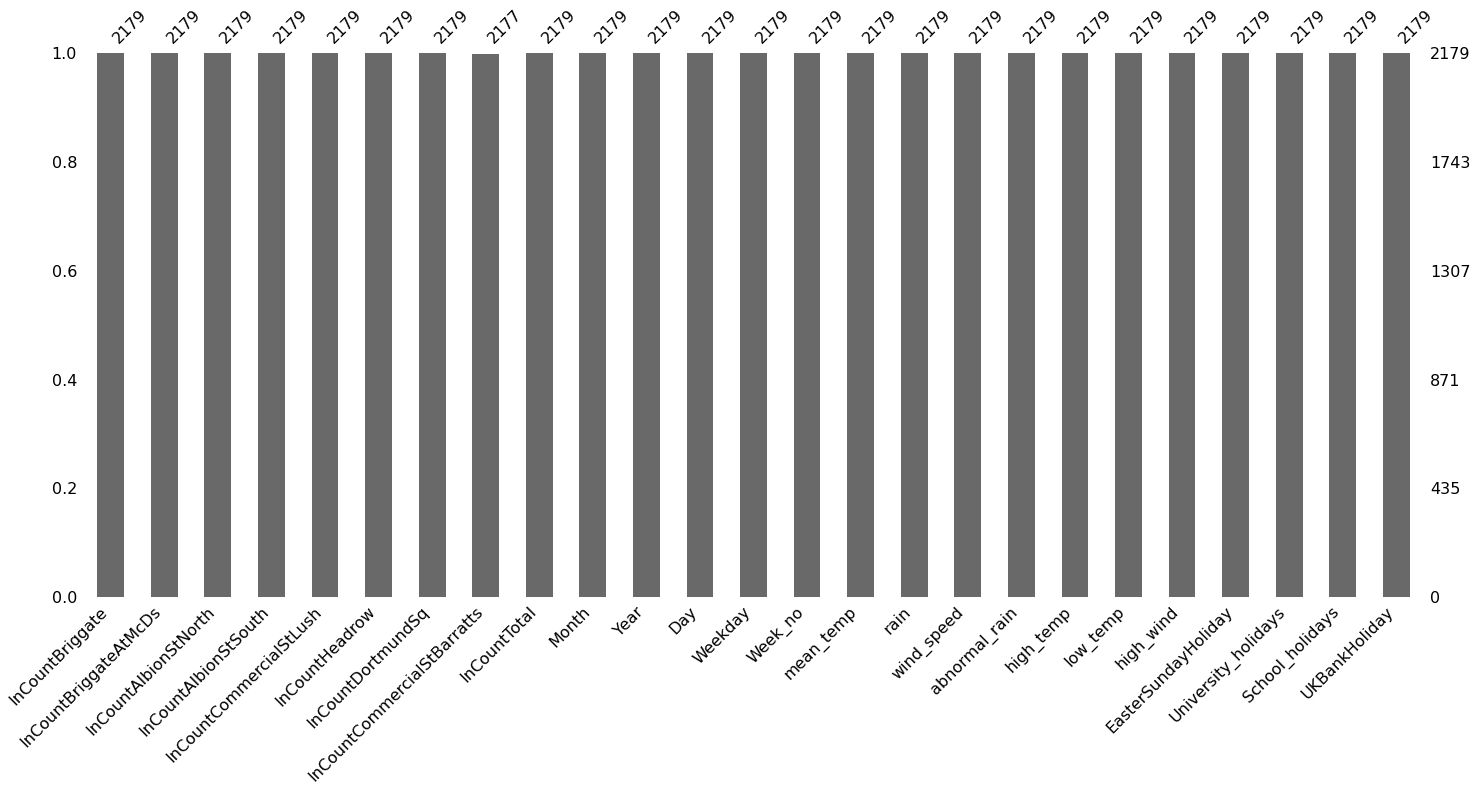

In [18]:
data_for_visualization,_,_,_ =  do_all_pre_processing(for_visualization_only = True)

# Observation :
1. Only Missing data in column InCountCommercialStBarrats.

In [19]:
data_for_visualization.head()

InCountBriggate  InCountBriggateAtMcDs  InCountAlbionStNorth  \
DateTime                                                                   
2011-01-01           9467.0                 7102.0                5231.0   
2011-01-02          25301.0                11546.0               19660.0   
2011-01-03          29684.0                12684.0               21773.0   
2011-01-04          35663.0                18484.0               25526.0   
2011-01-05          26538.0                 9361.0               10573.0   

            InCountAlbionStSouth  InCountCommercialStLush  InCountHeadrow  \
DateTime                                                                    
2011-01-01                5714.0                   5725.0          3571.0   
2011-01-02               23456.0                  23612.0          9496.0   
2011-01-03               23512.0                  29148.0         11064.0   
2011-01-04               31434.0                  38829.0         15068.0   
2011-01-05                9733.0                  16505.0          8281.0   

            InCountDortmundSq  InCountCommercialStBarratts  InCountTotal  \
DateTime                                                                   
2011-01-01             6052.0                       4905.0         47767   
2011-01-02            19989.0                      16110.0        149170   
2011-01-03            21238.0                      17330.0        166433   
2011-01-04            31595.0                      24229.0        220828   
2011-01-05            19130.0                      12049.0        112170   

            Month  ...  rain  wind_speed abnormal_rain  high_temp  low_temp  \
DateTime           ...                                                        
2011-01-01      1  ...   0.0         0.0             0          0         1   
2011-01-02      2  ...   0.0         0.5             0          0         0   
2011-01-03      3  ...   0.0         1.3             0          0         1   
2011-01-04      4  ...   0.0         3.9             0          0         0   
2011-01-05      5  ...   0.0         3.0             0          0         0   

            high_wind  EasterSundayHoliday  University_holidays  \
DateTime                                                          
2011-01-01          0                    0                    1   
2011-01-02          0                    0                    0   
2011-01-03          0                    0                    0   
2011-01-04          1                    0                    1   
2011-01-05          1                    0                    1   

            School_holidays  UKBankHoliday  
DateTime                                    
2011-01-01                1              0  
2011-01-02                0              0  
2011-01-03                0              0  
2011-01-04                1              0  
2011-01-05                0              0  

[5 rows x 25 columns]

In [20]:
data_final[['InCountTotal_lag7','InCountTotal_lag6','InCountTotal_lag5','InCountTotal_lag4','InCountTotal_lag3','InCountTotal_lag2','InCountTotal_lag1','InCountTotal','InCountTotal_forecast1']].head(15)

InCountTotal_lag7  InCountTotal_lag6  InCountTotal_lag5  \
DateTime                                                              
2011-01-08           0.226691           0.013606          -0.022669   
2011-01-09           0.056840           0.020564          -0.093740   
2011-01-10           0.169977           0.055673           0.284003   
2011-01-11          -0.126620           0.101710          -0.095038   
2011-01-12           0.237038           0.040289           0.088486   
2011-01-13          -0.102229          -0.054032           0.003163   
2011-01-14          -0.024744           0.032451          -0.010782   
2011-01-15           0.122310           0.079076          -0.070337   
2011-01-16          -0.194916          -0.344329          -0.162036   
2011-01-17          -0.206709          -0.024416          -0.159743   
2011-01-18           0.002566          -0.132762           0.009757   
2011-01-19          -0.105812           0.036707           0.007418   
2011-01-20           0.047058           0.017769          -0.072089   
2011-01-21           0.003438          -0.086421           0.187572   
2011-01-22           0.056064           0.330057           0.192436   

            InCountTotal_lag4  InCountTotal_lag3  InCountTotal_lag2  \
DateTime                                                              
2011-01-08          -0.136973           0.091357          -0.105392   
2011-01-09           0.134590          -0.062158          -0.013961   
2011-01-10           0.087255           0.135452           0.192646   
2011-01-11          -0.046841           0.010353          -0.032880   
2011-01-12           0.145681           0.102448          -0.046965   
2011-01-13          -0.040071          -0.189484          -0.007191   
2011-01-14          -0.160195           0.022098          -0.113230   
2011-01-15           0.111956          -0.023371           0.119147   
2011-01-16          -0.297364          -0.154845          -0.184134   
2011-01-17          -0.017225          -0.046514          -0.136372   
2011-01-18          -0.019532          -0.109391           0.164602   
2011-01-19          -0.082441           0.191552           0.053931   
2011-01-20           0.201903           0.064283           0.037301   
2011-01-21           0.049951           0.022970          -0.003980   
2011-01-22           0.165455           0.138505           0.128154   

            InCountTotal_lag1  InCountTotal  InCountTotal_forecast1  
DateTime                                                             
2011-01-08          -0.057195      0.320651                0.363884  
2011-01-09           0.043233      0.363884                0.513297  
2011-01-10           0.149413      0.513297                0.331004  
2011-01-11          -0.182293      0.331004                0.466332  
2011-01-12           0.135328      0.466332                0.323813  
2011-01-13          -0.142519      0.323813                0.353102  
2011-01-14           0.029289      0.353102                0.442961  
2011-01-15           0.089858      0.442961                0.168968  
2011-01-16          -0.273992      0.168968                0.306589  
2011-01-17           0.137620      0.306589                0.333570  
2011-01-18           0.026981      0.333570                0.360520  
2011-01-19           0.026950      0.360520                0.370871  
2011-01-20           0.010351      0.370871                0.356540  
2011-01-21          -0.014331      0.356540                0.499025  
2011-01-22           0.142485      0.499025                0.209436

In [21]:
data_final[data_final.isnull().any(1)]

Empty DataFrame
Columns: [InCountBriggate, InCountBriggateAtMcDs, InCountAlbionStNorth, InCountAlbionStSouth, InCountCommercialStLush, InCountHeadrow, InCountDortmundSq, InCountCommercialStBarratts, InCountTotal, Month, Year, Day, Weekday, Week_no, mean_temp, rain, wind_speed, abnormal_rain, high_temp, low_temp, high_wind, EasterSundayHoliday, University_holidays, School_holidays, UKBankHoliday, InCountTotal_lag1, InCountTotal_lag2, InCountTotal_lag3, InCountTotal_lag4, InCountTotal_lag5, InCountTotal_lag6, InCountTotal_lag7, InCountTotal_forecast1, InCountTotal_forecast2, InCountTotal_forecast3, InCountTotal_forecast4, InCountTotal_forecast5, InCountTotal_forecast6, InCountTotal_forecast7, Outliers_InCountBriggate, Outliers_InCountBriggateAtMcDs, Outliers_InCountAlbionStNorth, Outliers_InCountAlbionStSouth, Outliers_InCountCommercialStLush, Outliers_InCountHeadrow, Outliers_InCountDortmundSq, Outliers_InCountCommercialStBarratts, Lof_OutlierInCountBriggate, Lof_OutlierInCountBriggateAtMcDs, Lof_OutlierInCountAlbionStNorth, Lof_OutlierInCountAlbionStSouth, Lof_OutlierInCountCommercialStLush, Lof_OutlierInCountHeadrow, Lof_OutlierInCountDortmundSq, Lof_OutlierInCountCommercialStBarratts]
Index: []

[0 rows x 55 columns]

In [22]:
data_for_visualization[data_for_visualization.isnull().any(1)]

Empty DataFrame
Columns: [InCountBriggate, InCountBriggateAtMcDs, InCountAlbionStNorth, InCountAlbionStSouth, InCountCommercialStLush, InCountHeadrow, InCountDortmundSq, InCountCommercialStBarratts, InCountTotal, Month, Year, Day, Weekday, Week_no, mean_temp, rain, wind_speed, abnormal_rain, high_temp, low_temp, high_wind, EasterSundayHoliday, University_holidays, School_holidays, UKBankHoliday]
Index: []

[0 rows x 25 columns]

In [23]:
data_for_visualization.loc['2014-08-13':'2014-08-13']

InCountBriggate  InCountBriggateAtMcDs  InCountAlbionStNorth  \
DateTime                                                                   
2014-08-13          36808.0                16118.0               13989.0   

            InCountAlbionStSouth  InCountCommercialStLush  InCountHeadrow  \
DateTime                                                                    
2014-08-13               21940.0                  20797.0         11963.0   

            InCountDortmundSq  InCountCommercialStBarratts  InCountTotal  \
DateTime                                                                   
2014-08-13            18455.0                      14882.0        140070   

            Month  ...  rain  wind_speed abnormal_rain  high_temp  low_temp  \
DateTime           ...                                                        
2014-08-13      8  ...   0.1         2.5             0          1         0   

            high_wind  EasterSundayHoliday  University_holidays  \
DateTime                                                          
2014-08-13          0                    0                    1   

            School_holidays  UKBankHoliday  
DateTime                                    
2014-08-13                1              0  

[1 rows x 25 columns]

In [24]:
print(location_name_list)

['Briggate' 'BriggateAtMcDs' 'AlbionStNorth' 'AlbionStSouth'
 'CommercialStLush' 'Headrow' 'DortmundSq' 'CommercialStBarratts']


# 4. EDA (Exploratory Data Analysis)

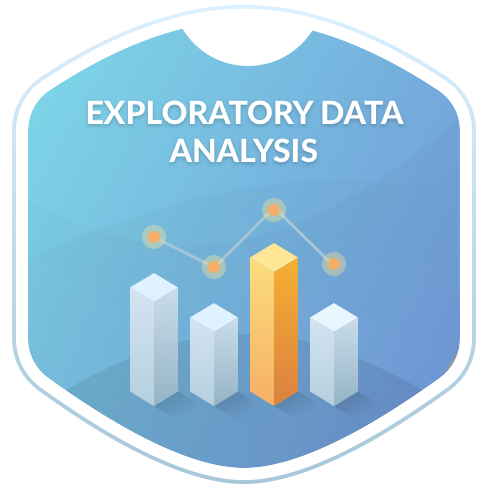

# 4.1 Data Visualization

In [25]:
class Visualization:
    def __init__(self,data_frame = None, location_name_list=None):
        self.data_frame = data_frame # array of column names to encode
        self.location_name_list = location_name_list
        self.colors = ['b','r','g','p']
        self.distmapping = { 'W': 'Weekly', 'M': 'Monthly','Y':'Yearly'}
        self.cols_to_keep = ['mean_temp','rain','wind_speed','abnormal_rain','high_temp','low_temp','high_wind','EasterSundayHoliday',
                             'University_holidays','School_holidays','UKBankHoliday']
        #self.cols_to_keep = [x for x in self.data_frame.columns if x not in ['InCount'+y for y in location_name_list]] 
        #self.cols_to_keep = [ x for x in self.cols_to_keep if 'Weekday_' not in x and 'Month_' not in x ]
        self.modified_location_name_list=['InCount'+x for x in self.location_name_list]
        #for i in range(len(location_name_list)):
          #  self.modified_location_name_list.append('InCount'+self.location_name_list[i])

    def plot_graphs(self, plot_type = 'boxplot', col_name = 'InCount', nplotrows=4,nplotcols=2):
        
        location_area_index = 0
        for i in range(nplotrows):# 4 rows of plots 
            fig = plt.figure(figsize=(16,8)) 
            for j in range(nplotcols):# 2 colums of sub plots
              ax1 = fig.add_subplot(1, 2, j+1)
              if(col_name == 'InCount'):
                target_variable = self.modified_location_name_list[location_area_index]
              else:
                target_variable = col_name                
            
              if(plot_type == 'boxplot'): 
                ax1.boxplot(self.data_frame[target_variable])
              elif(plot_type == 'histogram'):
                n, bins, patches = ax1.hist(self.data_frame[target_variable], bins=200, color=self.colors[j])
              elif(plot_type == 'heatmap'):
                cols = self.cols_to_keep.copy()
                cols.append(target_variable)
                sns.heatmap(self.data_frame[cols].corr(), annot=True, linewidths=.20)
                                        
              ax1.set_xlabel('Mall foot fall - ' + col_name + " for " + self.location_name_list[location_area_index] )
              ax1.set_ylabel('Frequency')
              ax1.set_title('Mall foot fall '+ plot_type +' - ' + col_name + " for " + self.location_name_list[location_area_index])
              location_area_index +=1
            
    def show_timedistribution(self, distribution_type='W', col_name='InCount'):
      for location_name in self.location_name_list:
        if(col_name == 'InCount'):
          target_variable = col_name + location_name
        else:
          target_variable = col_name
        self.data_frame[target_variable].resample(distribution_type).mean().plot(figsize = (20,8))
        
        xlabel = self.distmapping[distribution_type]
        plt.xlabel(xlabel)
        plt.ylabel('Mall Foot fall')
        plt.legend(self.location_name_list)
        plt.title("Mall Foot fall for different locations - " + xlabel)
    def show_pairplot(self,one_location_only = True, kind='scatter'):
      sns.set_style('whitegrid')
      cols = self.cols_to_keep
      cols.append('InCount'+self.location_name_list[0])
      sns.pairplot(self.data_frame[cols], kind=kind)

    def comparegates(self):
        gatecorrdata=data_final[self.modified_location_name_list]
        sns.pairplot(gatecorrdata)
        plt.show()
        sns.heatmap(gatecorrdata.corr(), annot = True)
        plt.show()

    def plot_graphs_for_list(self, plot_type = 'boxplot', col_list = ['rain']):
        
        col_index = 0
        nplotrows =1 
        nplotcols = 1
        if(len(col_list)>1):
          nplotrows = int(len(col_list)/2)
          nplotcols = 2
        for i in range(nplotrows):# 4 rows of plots 
            fig = plt.figure(figsize=(16,8)) 
            for j in range(nplotcols):# 2 colums of sub plots
              ax1 = fig.add_subplot(1, 2, j+1)

              col_name = col_list[col_index]           
              if(plot_type == 'boxplot'): 
                ax1.boxplot(self.data_frame[col_name])
              elif(plot_type == 'histogram'):
                n, bins, patches = ax1.hist(self.data_frame[col_name], bins=10, color=self.colors[j])
                                              
              ax1.set_xlabel('Mall foot fall - ' + col_name + " for " + self.location_name_list[0] )
              ax1.set_ylabel('Frequency')
              ax1.set_title('Mall foot fall '+ plot_type +' - ' + col_name + " for " + self.location_name_list[0])
              col_index +=1
           

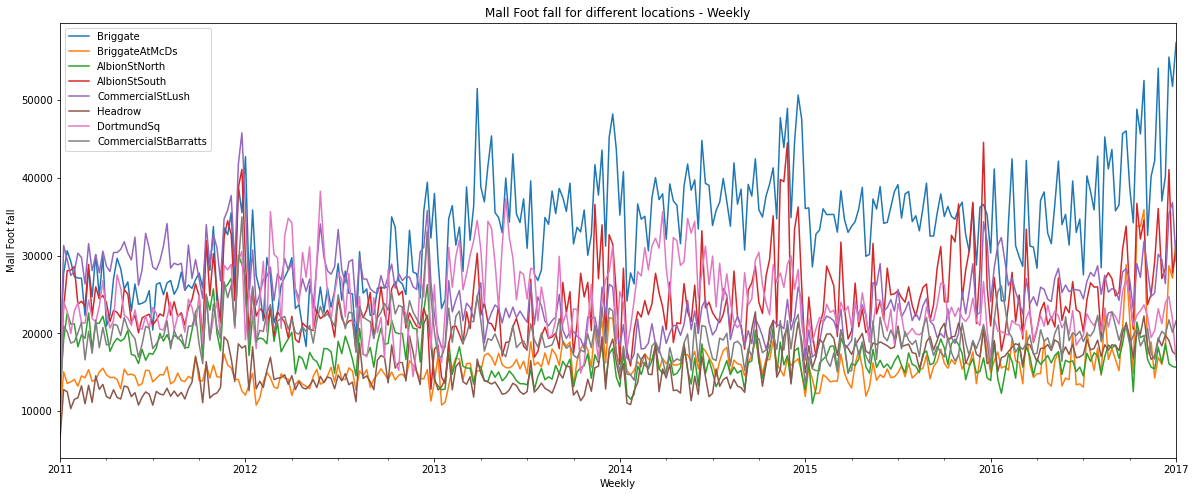

In [26]:
#from visualization import Visualization
graphs = Visualization(data_for_visualization,location_name_list)
graphs.show_timedistribution('W')

# Observations :
1. Incount is higher during the last weeks of Decemeber
2. 'Briggate' : There seems to be downward trend in 2015. overall, this seems to be the main gate
3. 'AlbionStNorth' : There is a downward trend throughout 




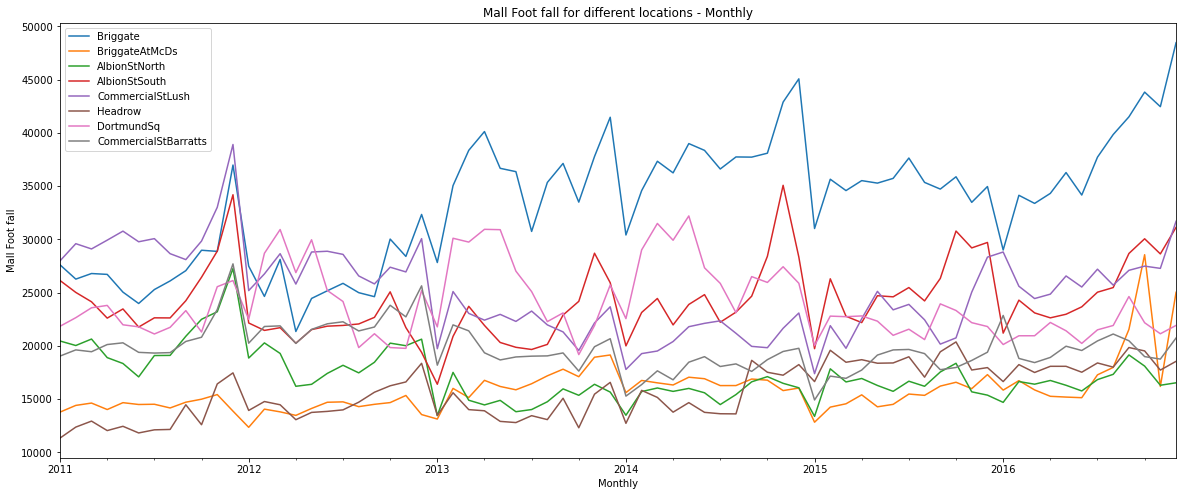

In [27]:
graphs.show_timedistribution('M')

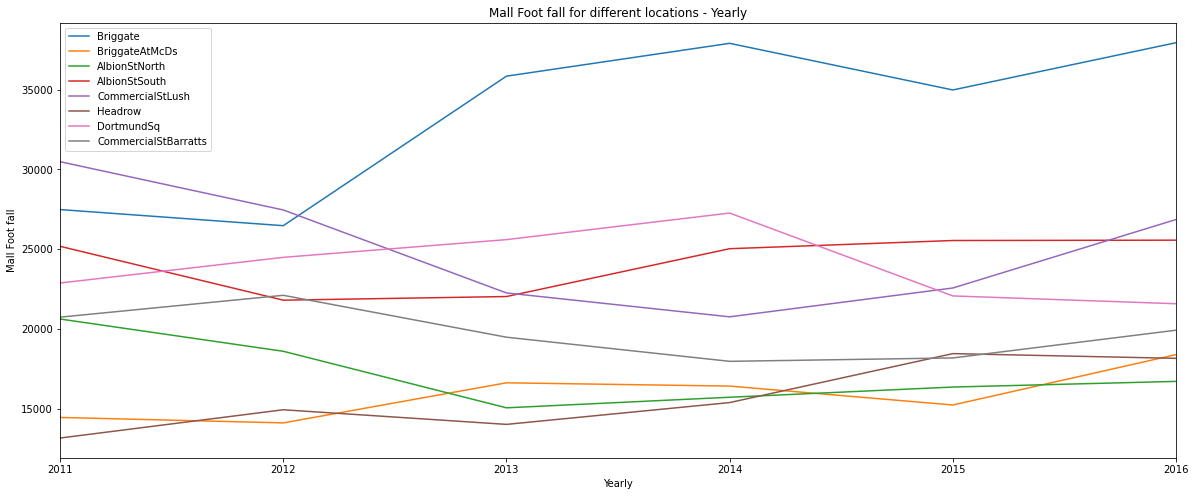

In [28]:
graphs.show_timedistribution('Y')

# 4.2 Histogram for InCount

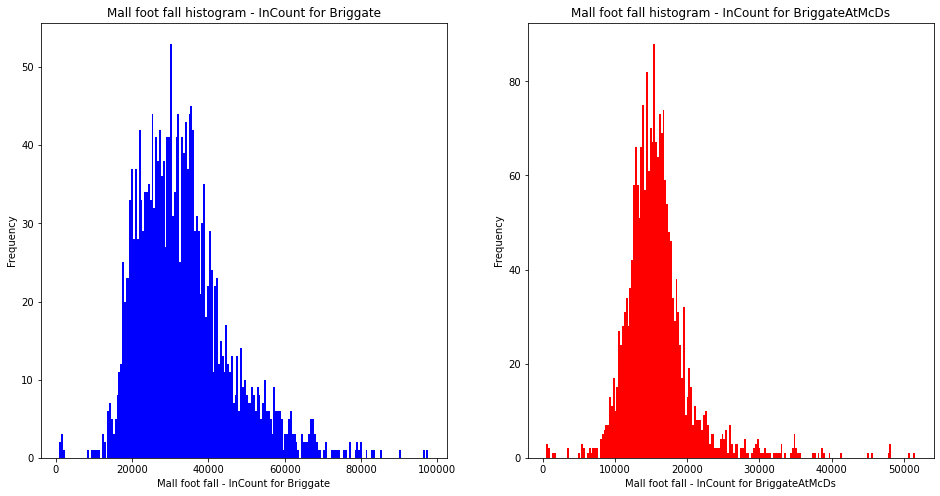

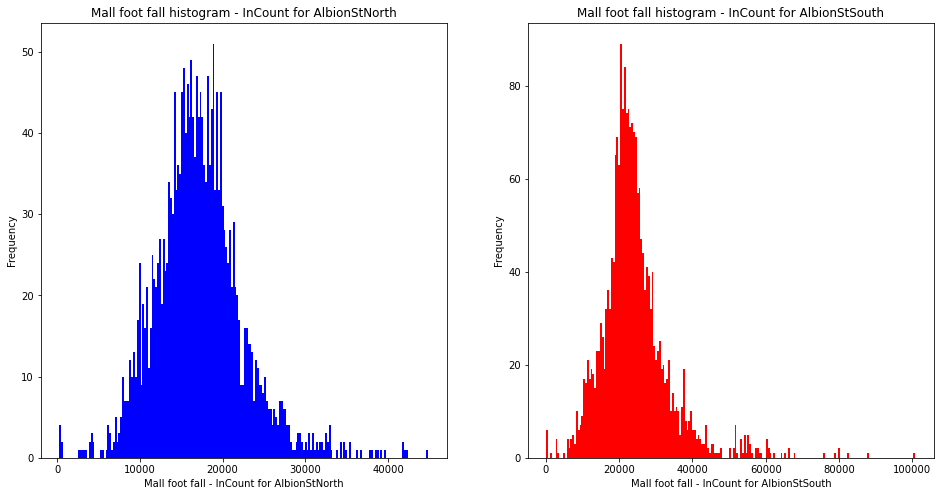

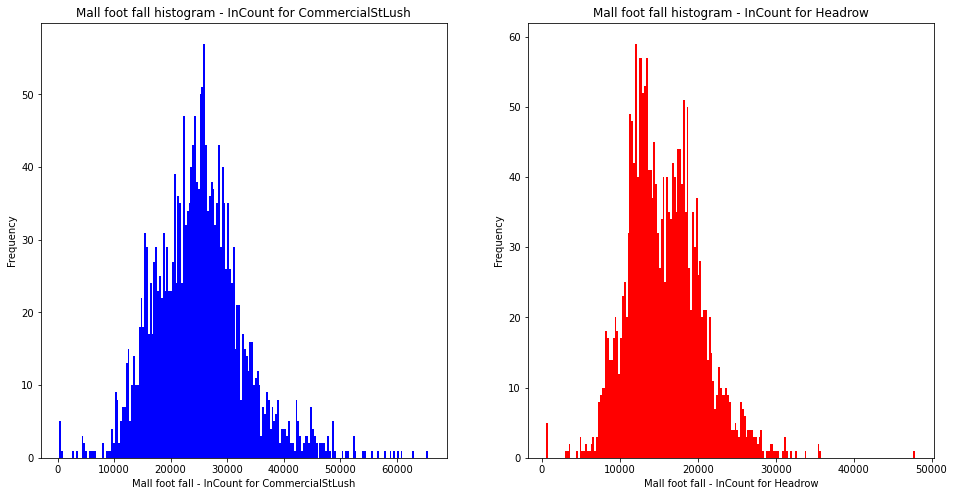

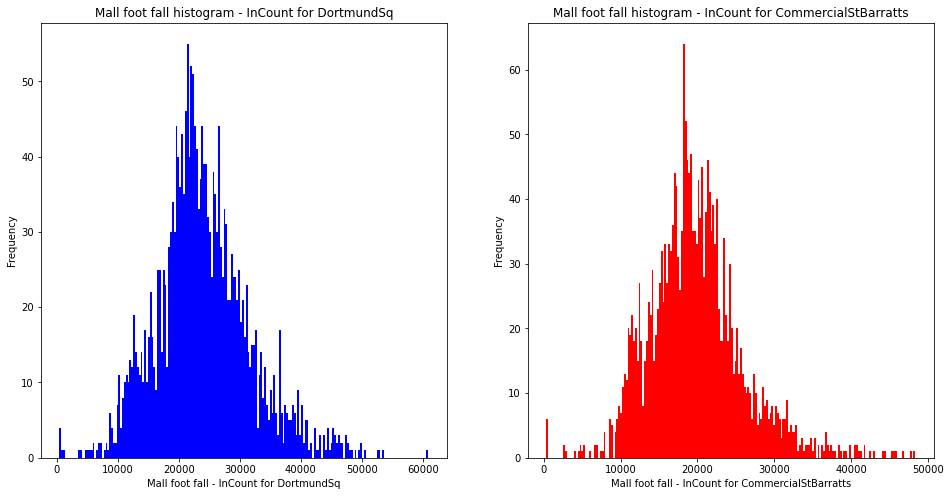

In [29]:
graphs.plot_graphs(plot_type = 'histogram')

# 4.3 Histogram for other attributes

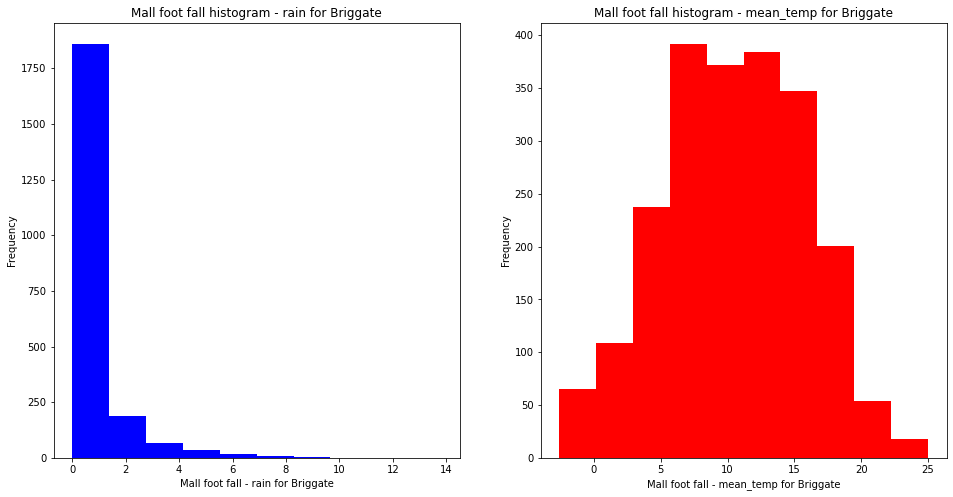

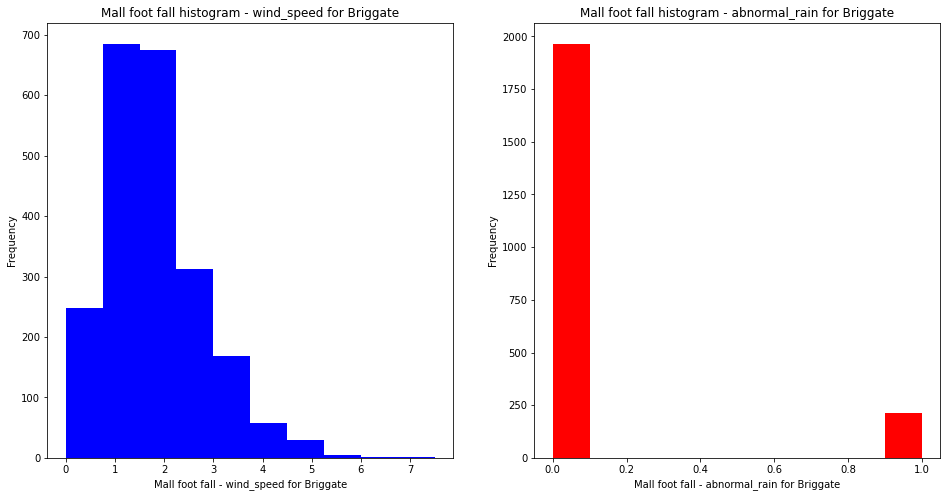

In [30]:
graphs.plot_graphs_for_list(plot_type = 'histogram', col_list =['rain','mean_temp','wind_speed','abnormal_rain'])

# 4.4 box plot (outlier) for InCount

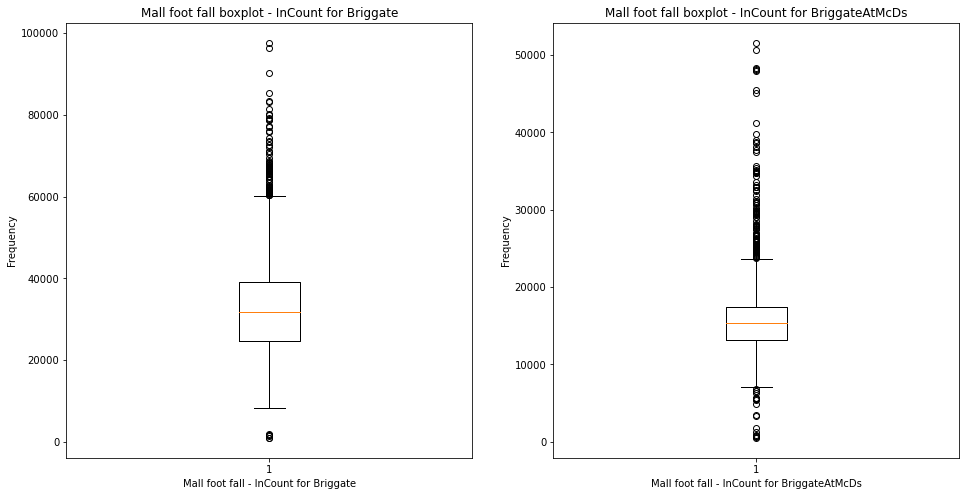

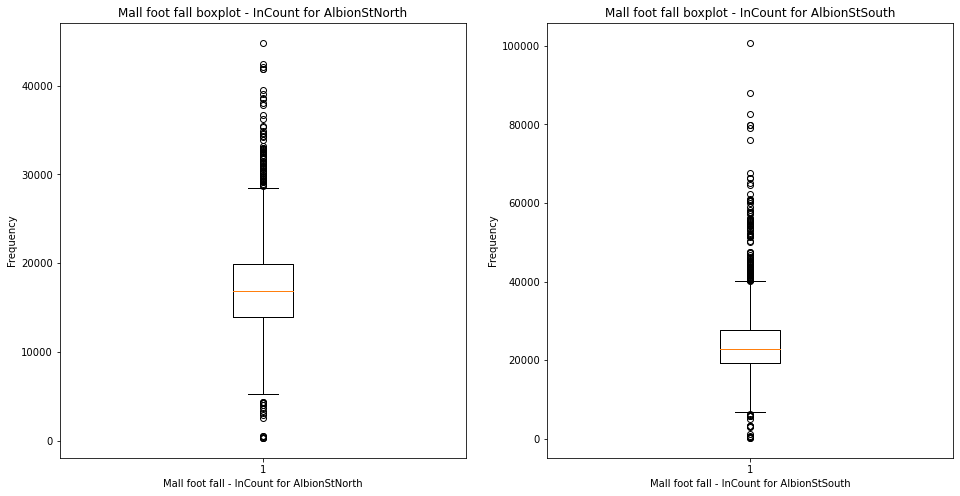

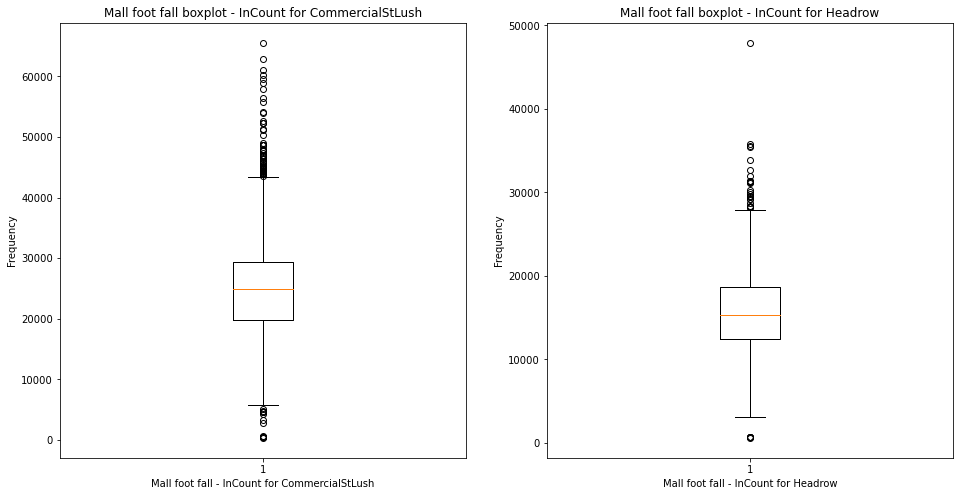

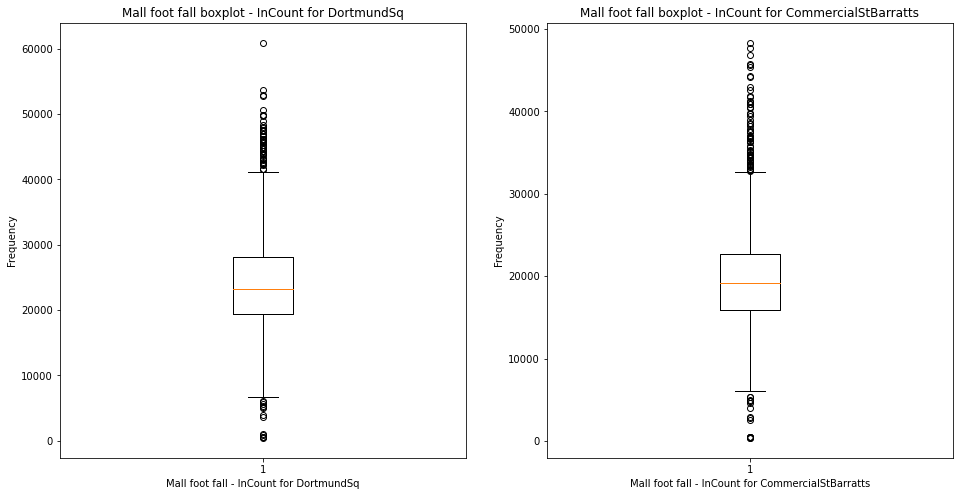

In [31]:
graphs.plot_graphs(plot_type = 'boxplot')

In [32]:
for location in graphs.modified_location_name_list:
  print(data_for_visualization[location].nlargest(2))

DateTime
2013-03-30    97623.0
2013-11-30    96325.0
Name: InCountBriggate, dtype: float64
DateTime
2016-03-12    51606.0
2016-10-12    50716.0
Name: InCountBriggateAtMcDs, dtype: float64
DateTime
2011-03-12    44852.0
2011-10-12    42398.0
Name: InCountAlbionStNorth, dtype: float64
DateTime
2014-11-29    100790.0
2016-03-12     88058.0
Name: InCountAlbionStSouth, dtype: float64
DateTime
2011-03-12    65560.0
2011-11-26    62929.0
Name: InCountCommercialStLush, dtype: float64
DateTime
2014-05-07    47913.0
2012-08-12    35750.0
Name: InCountHeadrow, dtype: float64
DateTime
2014-05-07    60911.0
2013-04-27    53649.0
Name: InCountDortmundSq, dtype: float64
DateTime
2011-10-12    48339.0
2012-12-15    47691.0
Name: InCountCommercialStBarratts, dtype: float64


# Observations : There are a few days where incount is much higher than other days

# 4.5 Boxplot for other attributes

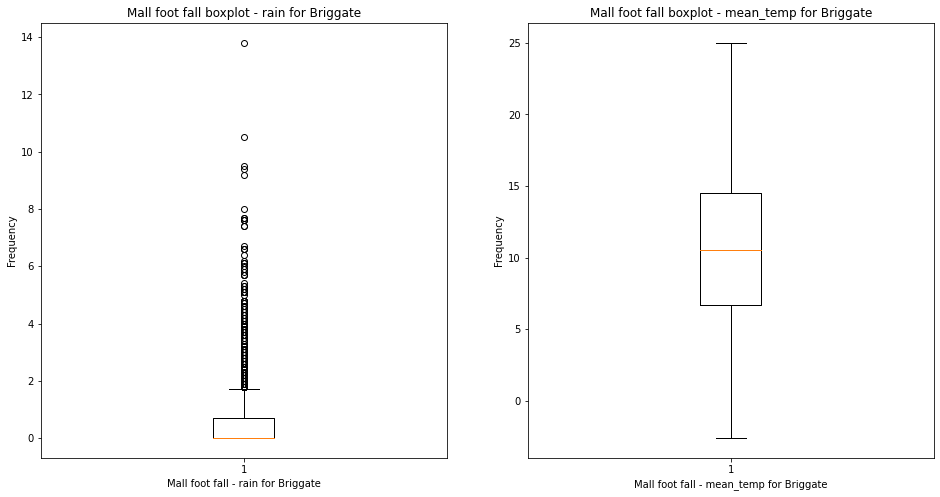

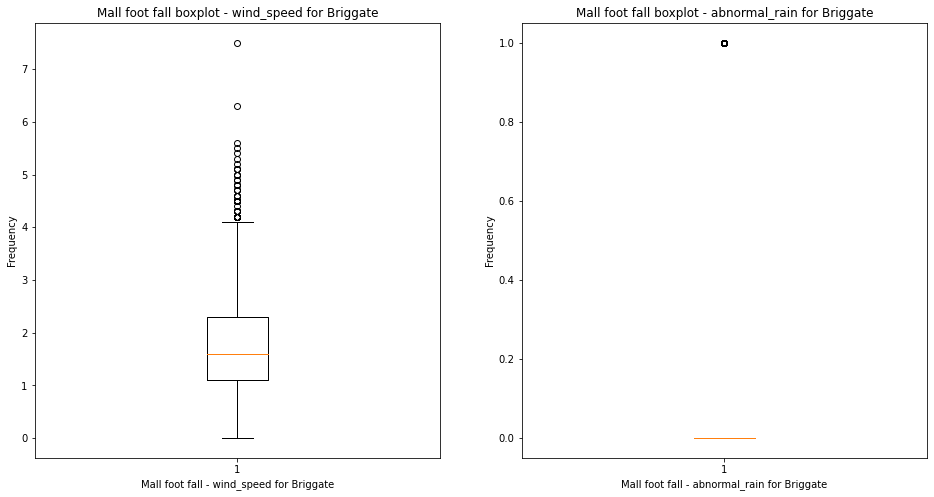

In [33]:
graphs.plot_graphs_for_list(plot_type = 'boxplot', col_list =['rain','mean_temp','wind_speed','abnormal_rain'])

# Observations :
1. mean_temp , abnormal_rain : no outliers
2. rain : There is one day with rain = 13.8
3. wind speed is high on a few days

# 4.5 Pair plots and heat maps

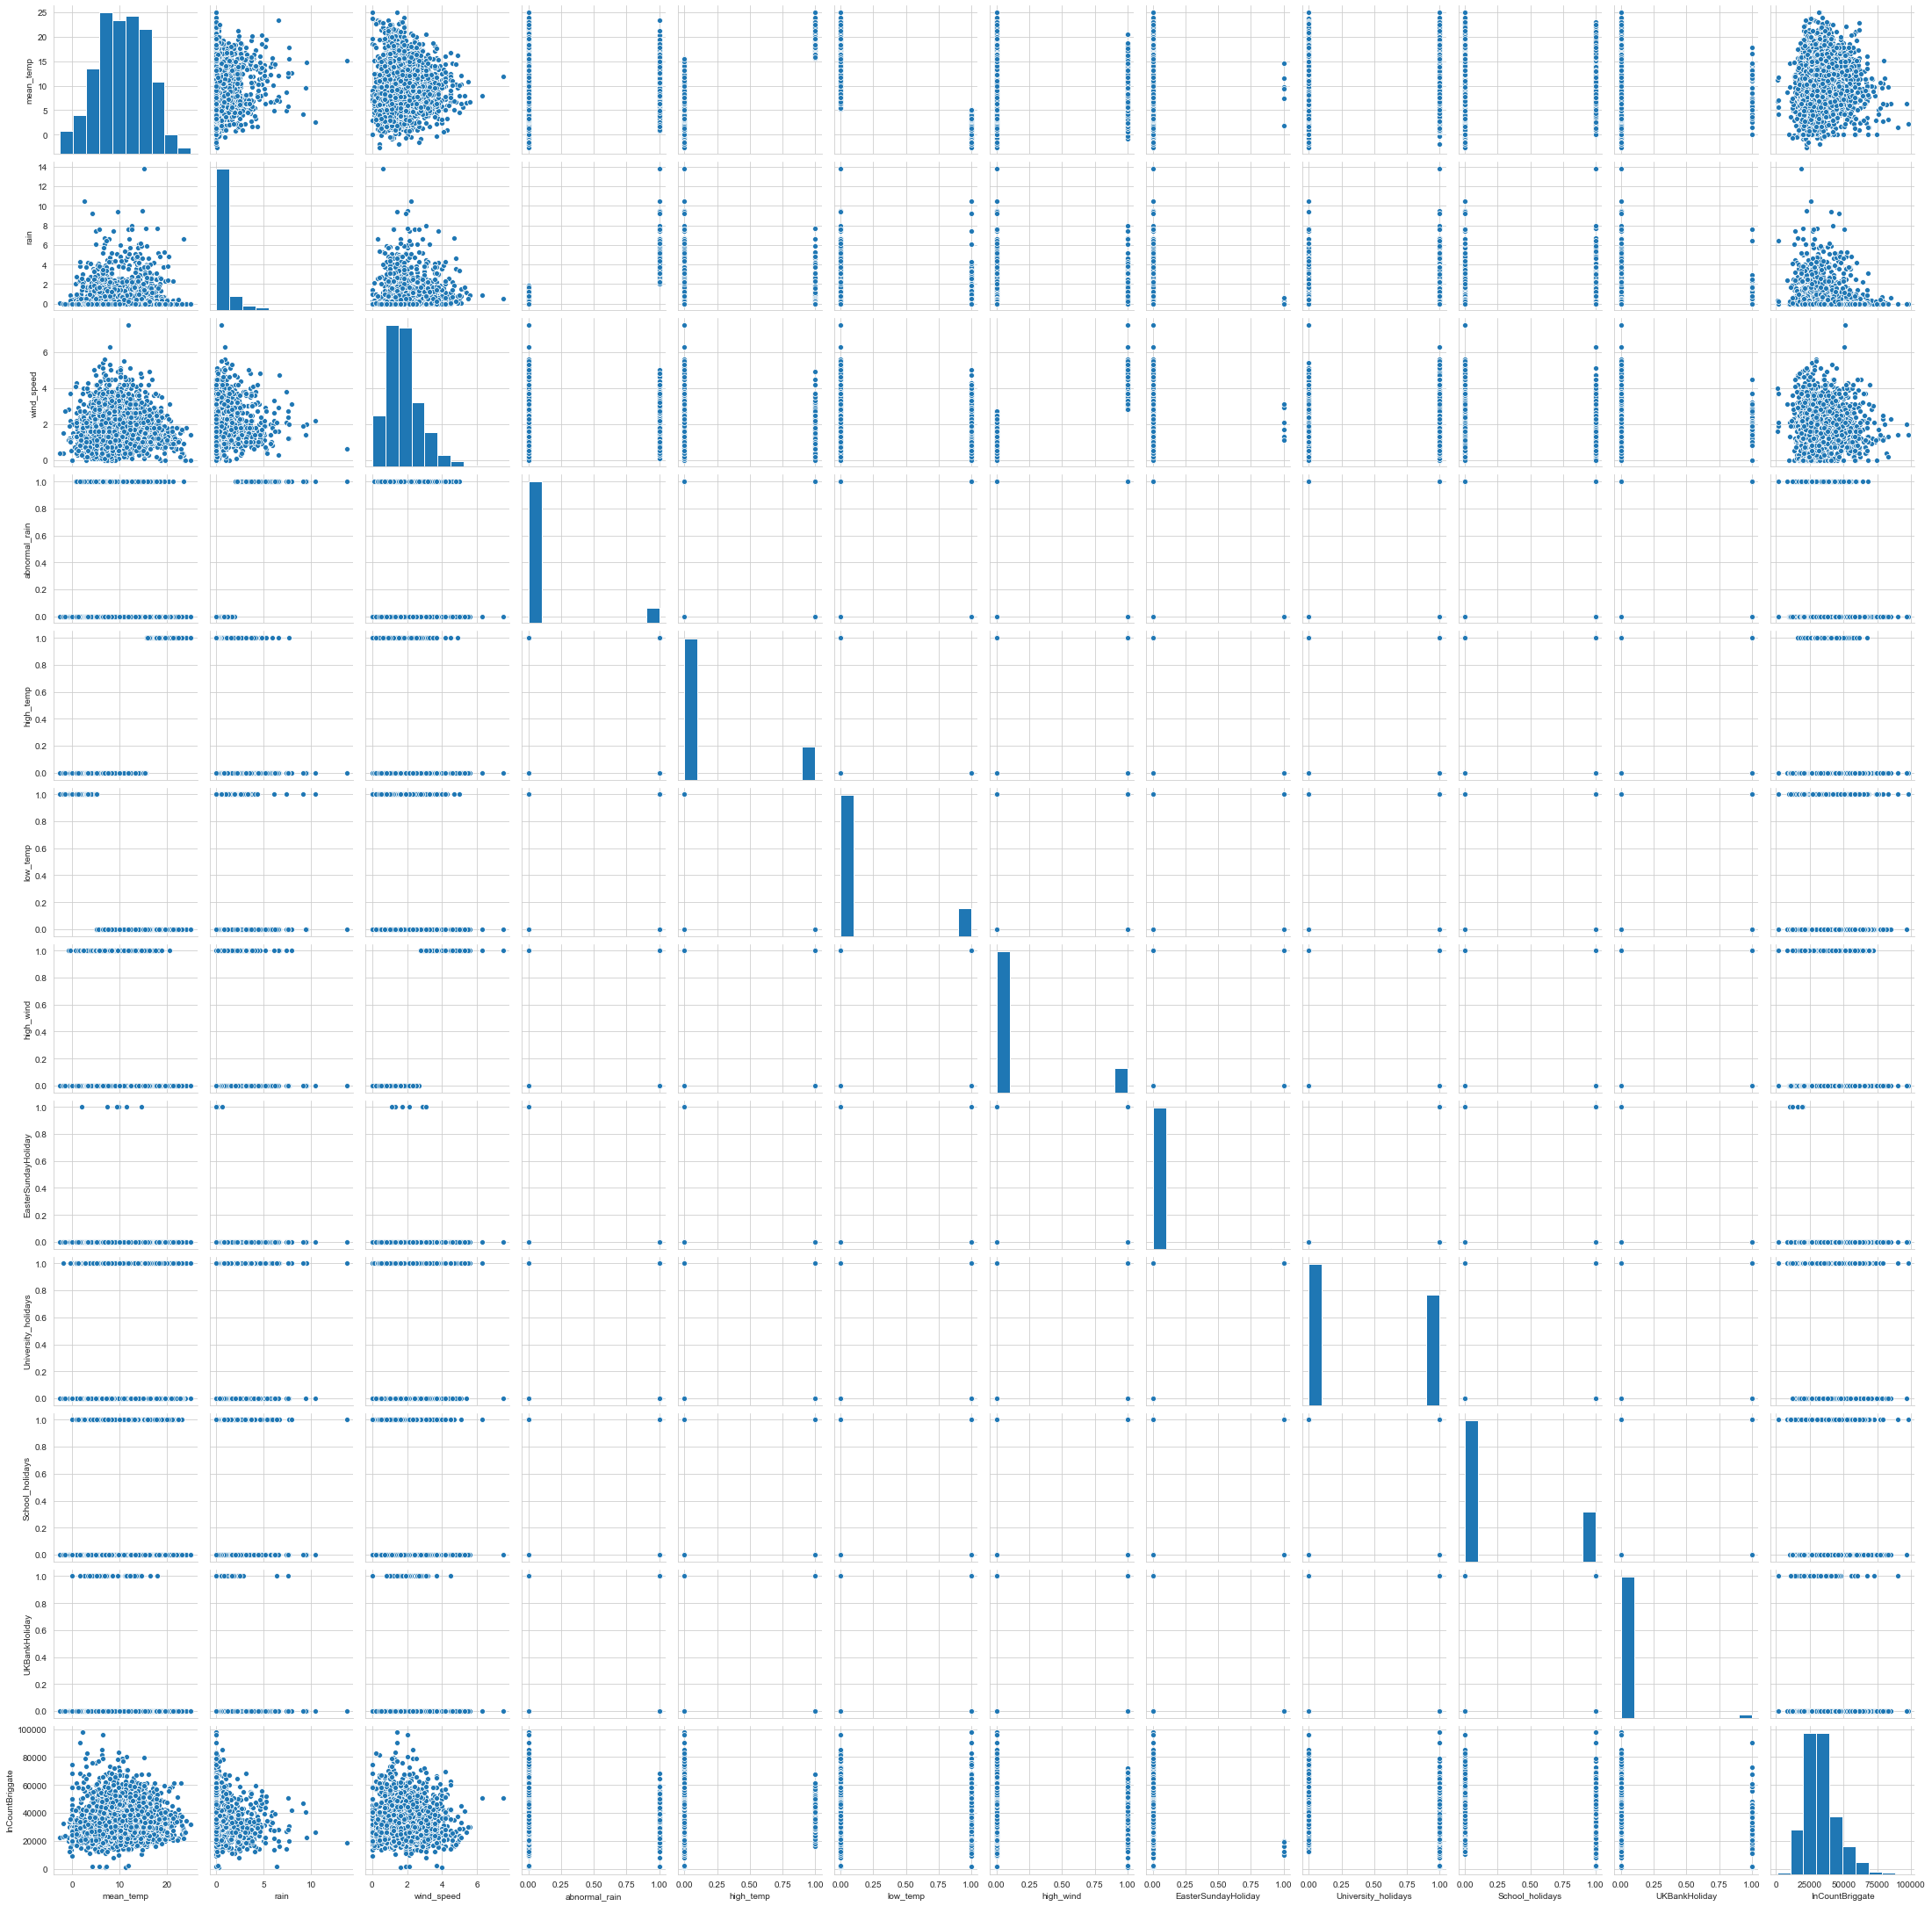

In [34]:
graphs.show_pairplot()

# observations :
1. rain : when there is no rain or less rain, incount is higher
2. wind-speed : When the wind-speed is lower, the incount is higher
3. abnormal_rain : when there is no abnormal_rain, incount is higher. linked with rain attribute
4. high_temp : when there is no high_temp, Incount is higher
5. low_temp : There is no impact on Incount if low_temp or not
6. high_wind : if there is no high_wind, Incount is higher
7. EasterSundayHoliday : if it's EasterSunday, the InCount is very **low**
8. School Holday/University Holiday - we do not see any major changes in the in-flow
9. UK Bank holiday - Incount is slighlty lower on bank holidays 

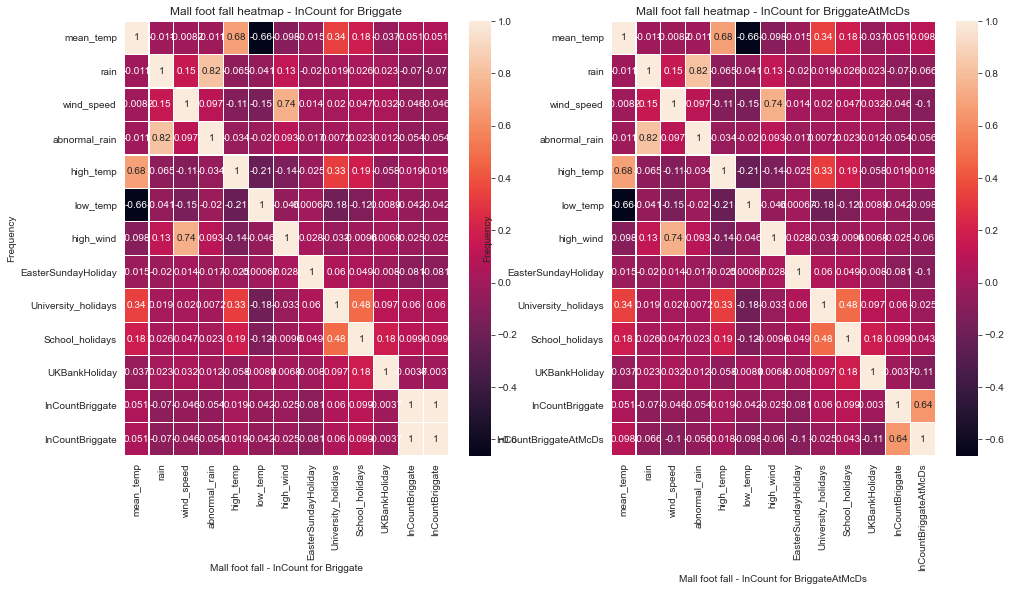

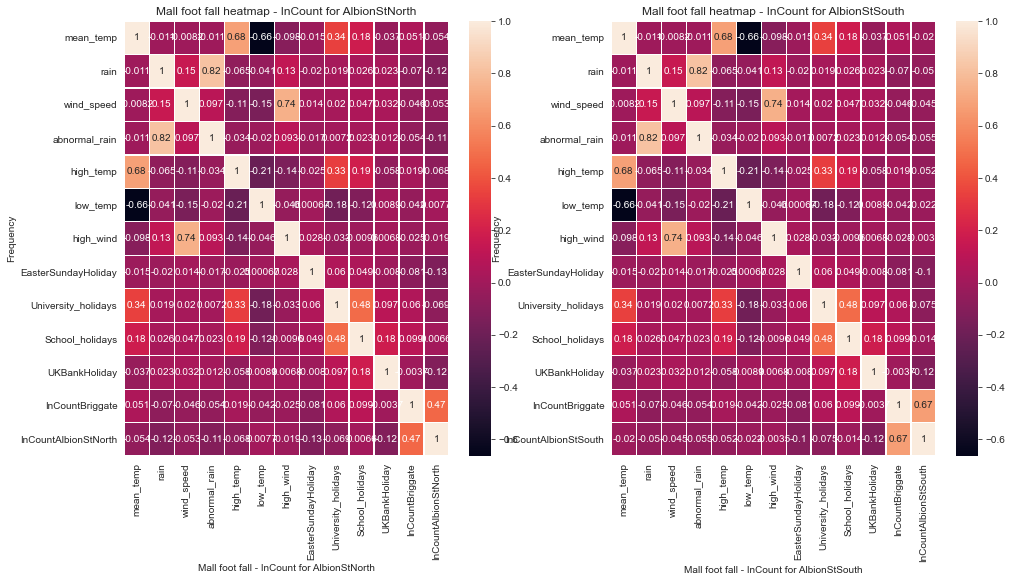

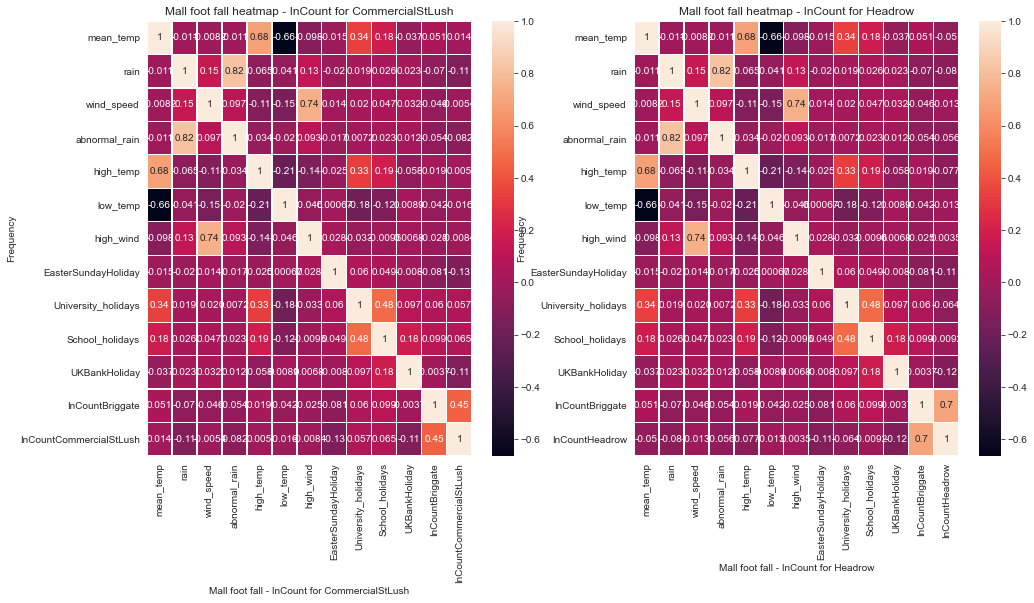

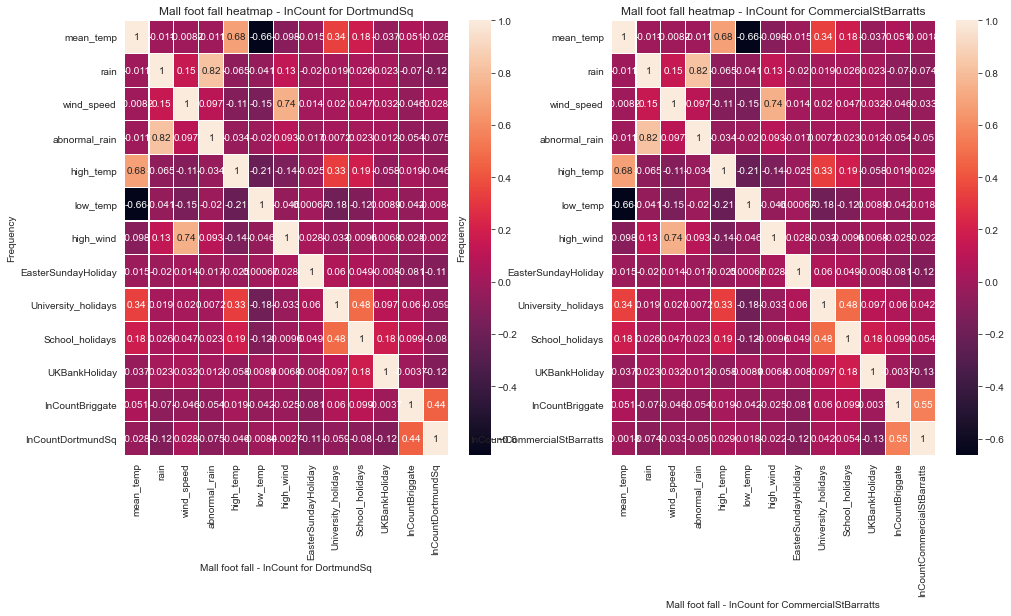

In [35]:
graphs.plot_graphs(plot_type='heatmap')

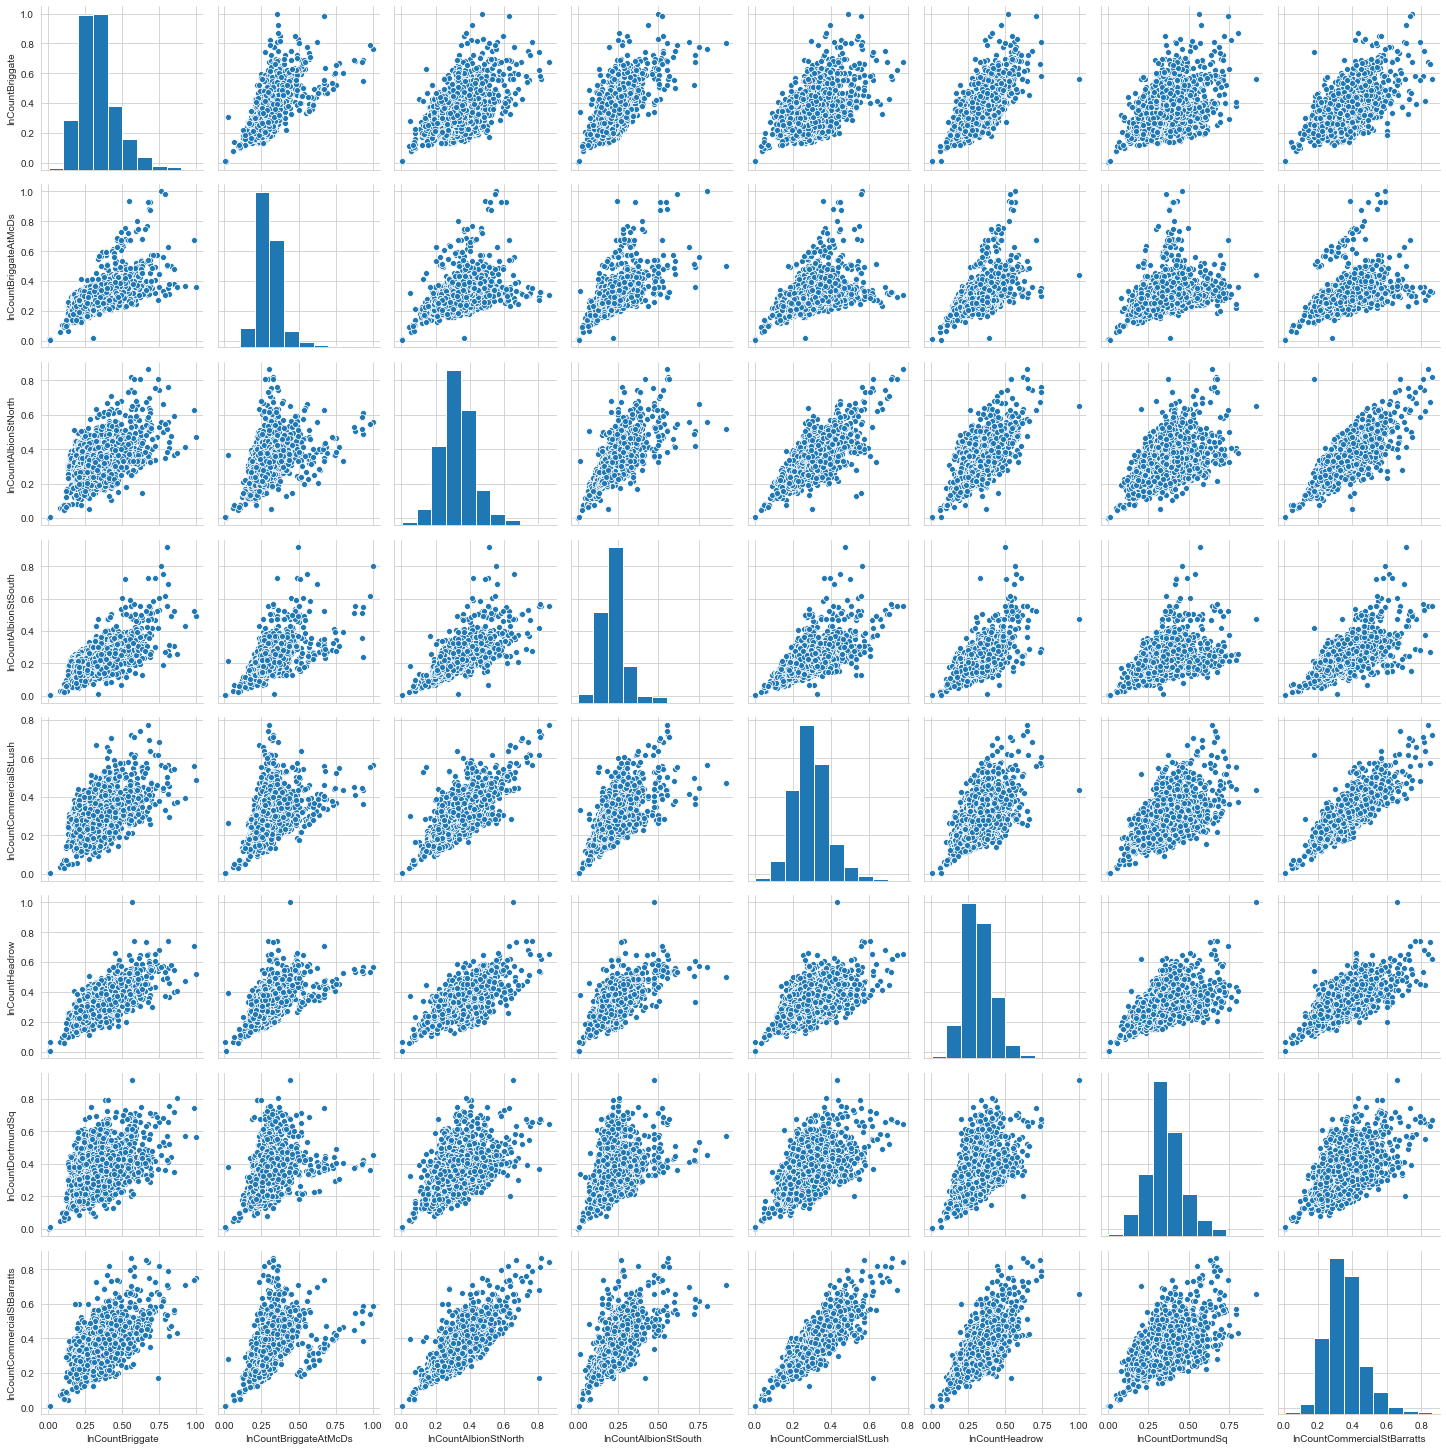

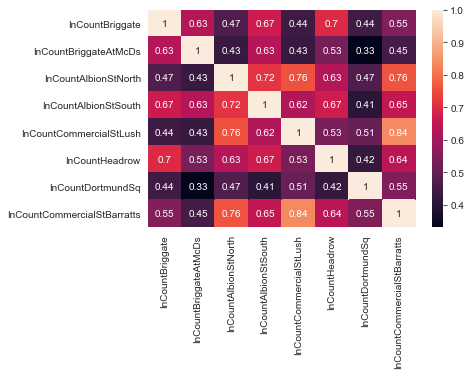

In [36]:
graphs.comparegates()

### Observation : The gates CommercialStLush and CommercialStBarratts are closely correlated